## Comment Classifcation using the BERT variants. 



In [1]:
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer,BertModel
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight



In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

## Read the data from the file. The data is in the form or comment tesxt \t Label

In [3]:
# # Removing unwanted columns and only leaving title of news and the category which will be the target
df = pd.read_csv("data/commentsPairs.txt", delimiter='\t',skiprows=1, names=[ 'TITLE','CATEGORY'])

df = df[['TITLE','CATEGORY']]
# df.head()

df=df[df['CATEGORY'].isin(['BUGGYCODE_SUGGESTION','REFACTORING_SUGGESTION','CODE_SUGGESTION','QUESTIONING',
                    'COMPLETENESS_SUGGESTION','LOGISTICS_SUGGESTION','LOGICAL_SUGGESTION','SPELLING_SUGGESTION',
                     'REUSE_SUGGESTION','DOCUMENTATION_SUGGESTION'])]


# # Converting the codes to appropriate categories using a dictionary
my_dict = {
    'BUGGYCODE_SUGGESTION': 0,
    'REFACTORING_SUGGESTION': 1,
    'CODE_SUGGESTION': 2,
    'QUESTIONING': 3,
    'COMPLETENESS_SUGGESTION':4,
    'LOGISTICS_SUGGESTION':5,
    'LOGICAL_SUGGESTION':6,
    'SPELLING_SUGGESTION':7,
    'REUSE_SUGGESTION':8,
    'DOCUMENTATION_SUGGESTION': 9
}

def update_cat(x):
    return my_dict[x]


In [4]:
encode_dict = {}
def encode_cat(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

df['ENCODE_CAT'] = df['CATEGORY'].apply(lambda x: encode_cat(x))

In [5]:
df

,TITLE,CATEGORY,ENCODE_CAT
0,please remove it and folder paymentsold comple...,CODE_SUGGESTION,0
1,are we are not using these strings ? then plea...,REFACTORING_SUGGESTION,1
2,call paymentid as warehouseid so that it s cle...,SPELLING_SUGGESTION,2
3,no need to make it caps button by default show...,CODE_SUGGESTION,0
4,follow no pending invoices instead of no pendi...,SPELLING_SUGGESTION,2
...,...,...,...
4855,there is issue in this query with single quote .,BUGGYCODE_SUGGESTION,3
4856,needs to be alter table invoicetemplatemapping...,CODE_SUGGESTION,0
4857,please swap the logic and use isset here . wil...,BUGGYCODE_SUGGESTION,3
4858,please make it re runable .,BUGGYCODE_SUGGESTION,3


####  Definign the Batch sizes and the pretrained model name

In [6]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
LEARNING_RATE = 1e-05
BERT_MODEL_NAME="bert-base-uncased"


## get the bert tokenizer

In [7]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME, do_lower_case=True)


## Define the DataSet claass 
The class will give a BERT compatible tokenized string
We will get the ids, attention mask and targets(labels) of the strings

In [8]:
class CustomDataSet(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.TITLE[index])
        title = " ".join(title.split())
        ## find out the ids and the masks
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.ENCODE_CAT[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [9]:
train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataSet(train_dataset, tokenizer, MAX_LEN)

testing_set = CustomDataSet(test_dataset, tokenizer, MAX_LEN)



FULL Dataset: (4764, 3)
TRAIN Dataset: (3811, 3)
TEST Dataset: (953, 3)


In [10]:
import numpy as np
train_labels=train_dataset['ENCODE_CAT'].values
test_labels=test_dataset['ENCODE_CAT'].values



In [11]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

## define the BERT class

In [12]:
class CustomBERTClass(torch.nn.Module):
    def __init__(self,bertModelName):
        super(CustomBERTClass, self).__init__()
        self.l1 = BertModel.from_pretrained(bertModelName,num_labels = 10)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 10)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.softmax(output)
        return output

In [13]:
model = CustomBERTClass(BERT_MODEL_NAME)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CustomBERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

## Loss function with class weights
Our classes are quite imbalace and hence we are trying to normalize the loss function by passing the class weigths. 
The class which occurs mostly is given less weight compared to teh class that appears often


In [14]:
## taken from https://github.com/nikhil6041/OLI-and-Meme-Classification/blob/b03d392ec62f9cd0da90c758860950ccf87115e7/train_custom_transformer_model.py#L38
def nll_loss_with_class_weights(class_wts,device):
    # convert class weights to tensor
    weights= torch.tensor(class_wts,dtype=torch.float)
    weights = weights.to(device)
    return nn.NLLLoss(weight=weights)

In [15]:
#loss_function = torch.nn.CrossEntropyLoss()

#loss_function=nn.NLLLoss()
## the classwts will be used to define the loss function
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)
print(f"Class weights => {class_wts}")
loss_function=nll_loss_with_class_weights(class_wts,device)
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

Class weights => [ 0.52857143  0.52930556  2.15310734  0.47578027  0.86810934  1.46015326
  1.33719298  1.15835866  7.622      13.61071429]


/home/gauravp/anaconda3/envs/rohitTransformer/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8 9], y=[1 5 3 ... 4 1 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [16]:
# for _,data in enumerate(training_loader, 0):
#     print(data)
#     break

## Train function 

In [17]:

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [18]:
def train(training_loader):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        #print(ids,targets)
        outputs = model(ids, mask)
        #print("outputs",outputs)
        loss = loss_function(outputs, targets)
        
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        print(nb_tr_steps,loss)
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    #print("total accurate during training",n_correct)
    #print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")
    torch.save(model.state_dict(), f'data/finetuned_BERT_epoch.model')

    return epoch_loss,epoch_accu,n_correct,model

## validation function

In [19]:
import numpy as np
def valid(model, testing_loader):
    model.eval()
    tr_loss=0
    nb_tr_steps=0
    nb_tr_examples=0
    n_correct = 0; n_wrong = 0; total = 0
    predictions, true_vals = [], []
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            preds=outputs.detach().cpu().numpy()
            #print(np.argmax(preds,axis=1).flatten(),targets)
            #preds_flat = np.argmax(preds, axis=1).flatten()
            #labels_flat = labels.flatten()
            #print(len(preds))
            ## the batches should be of the same size so the logic will discard the batch which is of different size
            if(len(preds)!=4):
                break
            loss = loss_function(outputs, targets)
            predictions.append(np.argmax(preds,axis=1).flatten())
            true_vals.append(targets.cpu().numpy())
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_loss,epoch_accu,predictions,true_vals,n_correct


### START THE TRAINING

In [20]:
EPOCHS=10
training_stats=[]
for epoch in range(EPOCHS):
    train_epoch_loss,train_epoch_accu,train_n_correct,model=train(training_loader)
    valid_epoch_loss,valid_epoch_accu,predictions,true_vals,valid_n_correct=valid(model, testing_loader)
    
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch + 1,
            'Train Loss': train_epoch_loss,
            'Valid Loss': valid_epoch_loss,
            'Train Accur':train_epoch_accu,
            'Valid Accur': valid_epoch_accu            
        }
    )

/home/gauravp/anaconda3/envs/rohitTransformer/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


1 tensor(2.2816, device='cuda:0', grad_fn=<NllLossBackward0>)
Training Loss per 5000 steps: 2.2816379070281982
Training Accuracy per 5000 steps: 25.0
2 tensor(2.3191, device='cuda:0', grad_fn=<NllLossBackward0>)
3 tensor(2.3827, device='cuda:0', grad_fn=<NllLossBackward0>)
4 tensor(2.1785, device='cuda:0', grad_fn=<NllLossBackward0>)
5 tensor(2.2492, device='cuda:0', grad_fn=<NllLossBackward0>)
6 tensor(2.1944, device='cuda:0', grad_fn=<NllLossBackward0>)
7 tensor(2.5040, device='cuda:0', grad_fn=<NllLossBackward0>)
8 tensor(2.2581, device='cuda:0', grad_fn=<NllLossBackward0>)
9 tensor(2.3627, device='cuda:0', grad_fn=<NllLossBackward0>)
10 tensor(2.1476, device='cuda:0', grad_fn=<NllLossBackward0>)
11 tensor(2.2774, device='cuda:0', grad_fn=<NllLossBackward0>)
12 tensor(2.2477, device='cuda:0', grad_fn=<NllLossBackward0>)
13 tensor(2.3310, device='cuda:0', grad_fn=<NllLossBackward0>)
14 tensor(2.2983, device='cuda:0', grad_fn=<NllLossBackward0>)
15 tensor(2.3307, device='cuda:0', grad

130 tensor(1.7575, device='cuda:0', grad_fn=<NllLossBackward0>)
131 tensor(2.2576, device='cuda:0', grad_fn=<NllLossBackward0>)
132 tensor(1.9215, device='cuda:0', grad_fn=<NllLossBackward0>)
133 tensor(2.3366, device='cuda:0', grad_fn=<NllLossBackward0>)
134 tensor(1.9580, device='cuda:0', grad_fn=<NllLossBackward0>)
135 tensor(2.0308, device='cuda:0', grad_fn=<NllLossBackward0>)
136 tensor(1.9366, device='cuda:0', grad_fn=<NllLossBackward0>)
137 tensor(2.0562, device='cuda:0', grad_fn=<NllLossBackward0>)
138 tensor(1.8725, device='cuda:0', grad_fn=<NllLossBackward0>)
139 tensor(1.8583, device='cuda:0', grad_fn=<NllLossBackward0>)
140 tensor(2.0825, device='cuda:0', grad_fn=<NllLossBackward0>)
141 tensor(2.3152, device='cuda:0', grad_fn=<NllLossBackward0>)
142 tensor(1.8018, device='cuda:0', grad_fn=<NllLossBackward0>)
143 tensor(1.8998, device='cuda:0', grad_fn=<NllLossBackward0>)
144 tensor(2.6718, device='cuda:0', grad_fn=<NllLossBackward0>)
145 tensor(1.8345, device='cuda:0', grad

259 tensor(1.2451, device='cuda:0', grad_fn=<NllLossBackward0>)
260 tensor(2.0970, device='cuda:0', grad_fn=<NllLossBackward0>)
261 tensor(1.7621, device='cuda:0', grad_fn=<NllLossBackward0>)
262 tensor(1.6627, device='cuda:0', grad_fn=<NllLossBackward0>)
263 tensor(3.0645, device='cuda:0', grad_fn=<NllLossBackward0>)
264 tensor(1.5661, device='cuda:0', grad_fn=<NllLossBackward0>)
265 tensor(1.5318, device='cuda:0', grad_fn=<NllLossBackward0>)
266 tensor(1.7860, device='cuda:0', grad_fn=<NllLossBackward0>)
267 tensor(1.8151, device='cuda:0', grad_fn=<NllLossBackward0>)
268 tensor(1.7697, device='cuda:0', grad_fn=<NllLossBackward0>)
269 tensor(2.1067, device='cuda:0', grad_fn=<NllLossBackward0>)
270 tensor(1.6226, device='cuda:0', grad_fn=<NllLossBackward0>)
271 tensor(1.4884, device='cuda:0', grad_fn=<NllLossBackward0>)
272 tensor(1.5288, device='cuda:0', grad_fn=<NllLossBackward0>)
273 tensor(1.6724, device='cuda:0', grad_fn=<NllLossBackward0>)
274 tensor(1.8773, device='cuda:0', grad

388 tensor(1.9571, device='cuda:0', grad_fn=<NllLossBackward0>)
389 tensor(2.6535, device='cuda:0', grad_fn=<NllLossBackward0>)
390 tensor(0.9089, device='cuda:0', grad_fn=<NllLossBackward0>)
391 tensor(2.0861, device='cuda:0', grad_fn=<NllLossBackward0>)
392 tensor(1.4361, device='cuda:0', grad_fn=<NllLossBackward0>)
393 tensor(2.0645, device='cuda:0', grad_fn=<NllLossBackward0>)
394 tensor(1.4564, device='cuda:0', grad_fn=<NllLossBackward0>)
395 tensor(2.3979, device='cuda:0', grad_fn=<NllLossBackward0>)
396 tensor(1.3476, device='cuda:0', grad_fn=<NllLossBackward0>)
397 tensor(1.1668, device='cuda:0', grad_fn=<NllLossBackward0>)
398 tensor(0.8820, device='cuda:0', grad_fn=<NllLossBackward0>)
399 tensor(1.7498, device='cuda:0', grad_fn=<NllLossBackward0>)
400 tensor(2.2188, device='cuda:0', grad_fn=<NllLossBackward0>)
401 tensor(1.1501, device='cuda:0', grad_fn=<NllLossBackward0>)
402 tensor(0.8682, device='cuda:0', grad_fn=<NllLossBackward0>)
403 tensor(1.5590, device='cuda:0', grad

517 tensor(1.0405, device='cuda:0', grad_fn=<NllLossBackward0>)
518 tensor(1.0123, device='cuda:0', grad_fn=<NllLossBackward0>)
519 tensor(0.9365, device='cuda:0', grad_fn=<NllLossBackward0>)
520 tensor(1.5194, device='cuda:0', grad_fn=<NllLossBackward0>)
521 tensor(1.3695, device='cuda:0', grad_fn=<NllLossBackward0>)
522 tensor(2.1720, device='cuda:0', grad_fn=<NllLossBackward0>)
523 tensor(1.2721, device='cuda:0', grad_fn=<NllLossBackward0>)
524 tensor(0.9048, device='cuda:0', grad_fn=<NllLossBackward0>)
525 tensor(1.6066, device='cuda:0', grad_fn=<NllLossBackward0>)
526 tensor(0.5141, device='cuda:0', grad_fn=<NllLossBackward0>)
527 tensor(1.5746, device='cuda:0', grad_fn=<NllLossBackward0>)
528 tensor(1.4620, device='cuda:0', grad_fn=<NllLossBackward0>)
529 tensor(1.7863, device='cuda:0', grad_fn=<NllLossBackward0>)
530 tensor(1.1718, device='cuda:0', grad_fn=<NllLossBackward0>)
531 tensor(1.5794, device='cuda:0', grad_fn=<NllLossBackward0>)
532 tensor(1.3120, device='cuda:0', grad

646 tensor(2.0651, device='cuda:0', grad_fn=<NllLossBackward0>)
647 tensor(0.7563, device='cuda:0', grad_fn=<NllLossBackward0>)
648 tensor(1.0181, device='cuda:0', grad_fn=<NllLossBackward0>)
649 tensor(2.3435, device='cuda:0', grad_fn=<NllLossBackward0>)
650 tensor(1.7536, device='cuda:0', grad_fn=<NllLossBackward0>)
651 tensor(1.9204, device='cuda:0', grad_fn=<NllLossBackward0>)
652 tensor(2.6275, device='cuda:0', grad_fn=<NllLossBackward0>)
653 tensor(2.1334, device='cuda:0', grad_fn=<NllLossBackward0>)
654 tensor(1.0926, device='cuda:0', grad_fn=<NllLossBackward0>)
655 tensor(1.0186, device='cuda:0', grad_fn=<NllLossBackward0>)
656 tensor(1.3376, device='cuda:0', grad_fn=<NllLossBackward0>)
657 tensor(1.2330, device='cuda:0', grad_fn=<NllLossBackward0>)
658 tensor(1.5213, device='cuda:0', grad_fn=<NllLossBackward0>)
659 tensor(0.8973, device='cuda:0', grad_fn=<NllLossBackward0>)
660 tensor(2.1125, device='cuda:0', grad_fn=<NllLossBackward0>)
661 tensor(0.6922, device='cuda:0', grad

775 tensor(1.1949, device='cuda:0', grad_fn=<NllLossBackward0>)
776 tensor(1.1813, device='cuda:0', grad_fn=<NllLossBackward0>)
777 tensor(0.4973, device='cuda:0', grad_fn=<NllLossBackward0>)
778 tensor(2.5529, device='cuda:0', grad_fn=<NllLossBackward0>)
779 tensor(2.4003, device='cuda:0', grad_fn=<NllLossBackward0>)
780 tensor(0.8165, device='cuda:0', grad_fn=<NllLossBackward0>)
781 tensor(0.3859, device='cuda:0', grad_fn=<NllLossBackward0>)
782 tensor(1.6544, device='cuda:0', grad_fn=<NllLossBackward0>)
783 tensor(1.6446, device='cuda:0', grad_fn=<NllLossBackward0>)
784 tensor(0.4054, device='cuda:0', grad_fn=<NllLossBackward0>)
785 tensor(1.1885, device='cuda:0', grad_fn=<NllLossBackward0>)
786 tensor(0.5500, device='cuda:0', grad_fn=<NllLossBackward0>)
787 tensor(0.9650, device='cuda:0', grad_fn=<NllLossBackward0>)
788 tensor(1.9923, device='cuda:0', grad_fn=<NllLossBackward0>)
789 tensor(1.9234, device='cuda:0', grad_fn=<NllLossBackward0>)
790 tensor(1.2780, device='cuda:0', grad

904 tensor(1.1187, device='cuda:0', grad_fn=<NllLossBackward0>)
905 tensor(0.6726, device='cuda:0', grad_fn=<NllLossBackward0>)
906 tensor(1.0492, device='cuda:0', grad_fn=<NllLossBackward0>)
907 tensor(0.6277, device='cuda:0', grad_fn=<NllLossBackward0>)
908 tensor(0.8620, device='cuda:0', grad_fn=<NllLossBackward0>)
909 tensor(0.7794, device='cuda:0', grad_fn=<NllLossBackward0>)
910 tensor(1.6834, device='cuda:0', grad_fn=<NllLossBackward0>)
911 tensor(1.3140, device='cuda:0', grad_fn=<NllLossBackward0>)
912 tensor(1.3413, device='cuda:0', grad_fn=<NllLossBackward0>)
913 tensor(0.7344, device='cuda:0', grad_fn=<NllLossBackward0>)
914 tensor(0.5292, device='cuda:0', grad_fn=<NllLossBackward0>)
915 tensor(2.1760, device='cuda:0', grad_fn=<NllLossBackward0>)
916 tensor(1.3672, device='cuda:0', grad_fn=<NllLossBackward0>)
917 tensor(1.1253, device='cuda:0', grad_fn=<NllLossBackward0>)
918 tensor(0.9021, device='cuda:0', grad_fn=<NllLossBackward0>)
919 tensor(0.4064, device='cuda:0', grad

75 tensor(0.7735, device='cuda:0', grad_fn=<NllLossBackward0>)
76 tensor(1.5939, device='cuda:0', grad_fn=<NllLossBackward0>)
77 tensor(2.1048, device='cuda:0', grad_fn=<NllLossBackward0>)
78 tensor(0.5807, device='cuda:0', grad_fn=<NllLossBackward0>)
79 tensor(2.2810, device='cuda:0', grad_fn=<NllLossBackward0>)
80 tensor(0.8709, device='cuda:0', grad_fn=<NllLossBackward0>)
81 tensor(0.8271, device='cuda:0', grad_fn=<NllLossBackward0>)
82 tensor(0.7610, device='cuda:0', grad_fn=<NllLossBackward0>)
83 tensor(0.5617, device='cuda:0', grad_fn=<NllLossBackward0>)
84 tensor(0.9077, device='cuda:0', grad_fn=<NllLossBackward0>)
85 tensor(0.3021, device='cuda:0', grad_fn=<NllLossBackward0>)
86 tensor(1.3368, device='cuda:0', grad_fn=<NllLossBackward0>)
87 tensor(0.5596, device='cuda:0', grad_fn=<NllLossBackward0>)
88 tensor(0.6867, device='cuda:0', grad_fn=<NllLossBackward0>)
89 tensor(0.7944, device='cuda:0', grad_fn=<NllLossBackward0>)
90 tensor(1.6455, device='cuda:0', grad_fn=<NllLossBack

204 tensor(0.4081, device='cuda:0', grad_fn=<NllLossBackward0>)
205 tensor(0.7161, device='cuda:0', grad_fn=<NllLossBackward0>)
206 tensor(0.8706, device='cuda:0', grad_fn=<NllLossBackward0>)
207 tensor(0.3638, device='cuda:0', grad_fn=<NllLossBackward0>)
208 tensor(0.5696, device='cuda:0', grad_fn=<NllLossBackward0>)
209 tensor(0.7007, device='cuda:0', grad_fn=<NllLossBackward0>)
210 tensor(1.4105, device='cuda:0', grad_fn=<NllLossBackward0>)
211 tensor(0.7658, device='cuda:0', grad_fn=<NllLossBackward0>)
212 tensor(1.1062, device='cuda:0', grad_fn=<NllLossBackward0>)
213 tensor(0.9905, device='cuda:0', grad_fn=<NllLossBackward0>)
214 tensor(1.8652, device='cuda:0', grad_fn=<NllLossBackward0>)
215 tensor(0.9928, device='cuda:0', grad_fn=<NllLossBackward0>)
216 tensor(1.2667, device='cuda:0', grad_fn=<NllLossBackward0>)
217 tensor(1.5552, device='cuda:0', grad_fn=<NllLossBackward0>)
218 tensor(0.9103, device='cuda:0', grad_fn=<NllLossBackward0>)
219 tensor(1.2429, device='cuda:0', grad

333 tensor(0.3040, device='cuda:0', grad_fn=<NllLossBackward0>)
334 tensor(1.0200, device='cuda:0', grad_fn=<NllLossBackward0>)
335 tensor(0.4540, device='cuda:0', grad_fn=<NllLossBackward0>)
336 tensor(1.1694, device='cuda:0', grad_fn=<NllLossBackward0>)
337 tensor(1.8551, device='cuda:0', grad_fn=<NllLossBackward0>)
338 tensor(2.7186, device='cuda:0', grad_fn=<NllLossBackward0>)
339 tensor(1.6117, device='cuda:0', grad_fn=<NllLossBackward0>)
340 tensor(1.4224, device='cuda:0', grad_fn=<NllLossBackward0>)
341 tensor(2.1917, device='cuda:0', grad_fn=<NllLossBackward0>)
342 tensor(1.2358, device='cuda:0', grad_fn=<NllLossBackward0>)
343 tensor(1.7162, device='cuda:0', grad_fn=<NllLossBackward0>)
344 tensor(0.5419, device='cuda:0', grad_fn=<NllLossBackward0>)
345 tensor(1.2290, device='cuda:0', grad_fn=<NllLossBackward0>)
346 tensor(0.7788, device='cuda:0', grad_fn=<NllLossBackward0>)
347 tensor(0.5129, device='cuda:0', grad_fn=<NllLossBackward0>)
348 tensor(0.7114, device='cuda:0', grad

462 tensor(0.3820, device='cuda:0', grad_fn=<NllLossBackward0>)
463 tensor(1.3769, device='cuda:0', grad_fn=<NllLossBackward0>)
464 tensor(0.3988, device='cuda:0', grad_fn=<NllLossBackward0>)
465 tensor(2.5527, device='cuda:0', grad_fn=<NllLossBackward0>)
466 tensor(1.5608, device='cuda:0', grad_fn=<NllLossBackward0>)
467 tensor(1.1037, device='cuda:0', grad_fn=<NllLossBackward0>)
468 tensor(0.9636, device='cuda:0', grad_fn=<NllLossBackward0>)
469 tensor(1.6946, device='cuda:0', grad_fn=<NllLossBackward0>)
470 tensor(1.5611, device='cuda:0', grad_fn=<NllLossBackward0>)
471 tensor(0.6478, device='cuda:0', grad_fn=<NllLossBackward0>)
472 tensor(0.8457, device='cuda:0', grad_fn=<NllLossBackward0>)
473 tensor(1.6511, device='cuda:0', grad_fn=<NllLossBackward0>)
474 tensor(0.6166, device='cuda:0', grad_fn=<NllLossBackward0>)
475 tensor(1.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
476 tensor(0.7057, device='cuda:0', grad_fn=<NllLossBackward0>)
477 tensor(0.4899, device='cuda:0', grad

591 tensor(1.8137, device='cuda:0', grad_fn=<NllLossBackward0>)
592 tensor(0.2210, device='cuda:0', grad_fn=<NllLossBackward0>)
593 tensor(1.4921, device='cuda:0', grad_fn=<NllLossBackward0>)
594 tensor(0.7660, device='cuda:0', grad_fn=<NllLossBackward0>)
595 tensor(1.6012, device='cuda:0', grad_fn=<NllLossBackward0>)
596 tensor(1.7701, device='cuda:0', grad_fn=<NllLossBackward0>)
597 tensor(0.1708, device='cuda:0', grad_fn=<NllLossBackward0>)
598 tensor(0.9140, device='cuda:0', grad_fn=<NllLossBackward0>)
599 tensor(2.9518, device='cuda:0', grad_fn=<NllLossBackward0>)
600 tensor(0.3818, device='cuda:0', grad_fn=<NllLossBackward0>)
601 tensor(0.2105, device='cuda:0', grad_fn=<NllLossBackward0>)
602 tensor(0.6468, device='cuda:0', grad_fn=<NllLossBackward0>)
603 tensor(1.0661, device='cuda:0', grad_fn=<NllLossBackward0>)
604 tensor(2.4639, device='cuda:0', grad_fn=<NllLossBackward0>)
605 tensor(0.7717, device='cuda:0', grad_fn=<NllLossBackward0>)
606 tensor(0.9452, device='cuda:0', grad

720 tensor(1.0090, device='cuda:0', grad_fn=<NllLossBackward0>)
721 tensor(0.3934, device='cuda:0', grad_fn=<NllLossBackward0>)
722 tensor(1.2536, device='cuda:0', grad_fn=<NllLossBackward0>)
723 tensor(0.2750, device='cuda:0', grad_fn=<NllLossBackward0>)
724 tensor(0.9179, device='cuda:0', grad_fn=<NllLossBackward0>)
725 tensor(0.4293, device='cuda:0', grad_fn=<NllLossBackward0>)
726 tensor(0.5857, device='cuda:0', grad_fn=<NllLossBackward0>)
727 tensor(0.9785, device='cuda:0', grad_fn=<NllLossBackward0>)
728 tensor(2.5563, device='cuda:0', grad_fn=<NllLossBackward0>)
729 tensor(2.0359, device='cuda:0', grad_fn=<NllLossBackward0>)
730 tensor(0.3552, device='cuda:0', grad_fn=<NllLossBackward0>)
731 tensor(1.0577, device='cuda:0', grad_fn=<NllLossBackward0>)
732 tensor(0.5311, device='cuda:0', grad_fn=<NllLossBackward0>)
733 tensor(1.1071, device='cuda:0', grad_fn=<NllLossBackward0>)
734 tensor(0.9469, device='cuda:0', grad_fn=<NllLossBackward0>)
735 tensor(0.8602, device='cuda:0', grad

849 tensor(1.0129, device='cuda:0', grad_fn=<NllLossBackward0>)
850 tensor(0.5281, device='cuda:0', grad_fn=<NllLossBackward0>)
851 tensor(2.1457, device='cuda:0', grad_fn=<NllLossBackward0>)
852 tensor(2.1048, device='cuda:0', grad_fn=<NllLossBackward0>)
853 tensor(1.3839, device='cuda:0', grad_fn=<NllLossBackward0>)
854 tensor(0.4254, device='cuda:0', grad_fn=<NllLossBackward0>)
855 tensor(1.0679, device='cuda:0', grad_fn=<NllLossBackward0>)
856 tensor(1.6511, device='cuda:0', grad_fn=<NllLossBackward0>)
857 tensor(0.4430, device='cuda:0', grad_fn=<NllLossBackward0>)
858 tensor(1.1375, device='cuda:0', grad_fn=<NllLossBackward0>)
859 tensor(1.6711, device='cuda:0', grad_fn=<NllLossBackward0>)
860 tensor(0.8638, device='cuda:0', grad_fn=<NllLossBackward0>)
861 tensor(0.8586, device='cuda:0', grad_fn=<NllLossBackward0>)
862 tensor(0.3519, device='cuda:0', grad_fn=<NllLossBackward0>)
863 tensor(0.2604, device='cuda:0', grad_fn=<NllLossBackward0>)
864 tensor(0.7000, device='cuda:0', grad

19 tensor(0.7463, device='cuda:0', grad_fn=<NllLossBackward0>)
20 tensor(0.5772, device='cuda:0', grad_fn=<NllLossBackward0>)
21 tensor(1.0199, device='cuda:0', grad_fn=<NllLossBackward0>)
22 tensor(0.2320, device='cuda:0', grad_fn=<NllLossBackward0>)
23 tensor(0.4471, device='cuda:0', grad_fn=<NllLossBackward0>)
24 tensor(0.4446, device='cuda:0', grad_fn=<NllLossBackward0>)
25 tensor(0.5858, device='cuda:0', grad_fn=<NllLossBackward0>)
26 tensor(0.1608, device='cuda:0', grad_fn=<NllLossBackward0>)
27 tensor(0.7598, device='cuda:0', grad_fn=<NllLossBackward0>)
28 tensor(0.8928, device='cuda:0', grad_fn=<NllLossBackward0>)
29 tensor(0.0972, device='cuda:0', grad_fn=<NllLossBackward0>)
30 tensor(0.2779, device='cuda:0', grad_fn=<NllLossBackward0>)
31 tensor(0.3309, device='cuda:0', grad_fn=<NllLossBackward0>)
32 tensor(0.7609, device='cuda:0', grad_fn=<NllLossBackward0>)
33 tensor(0.3032, device='cuda:0', grad_fn=<NllLossBackward0>)
34 tensor(0.1751, device='cuda:0', grad_fn=<NllLossBack

149 tensor(0.8326, device='cuda:0', grad_fn=<NllLossBackward0>)
150 tensor(0.4492, device='cuda:0', grad_fn=<NllLossBackward0>)
151 tensor(0.3683, device='cuda:0', grad_fn=<NllLossBackward0>)
152 tensor(1.2223, device='cuda:0', grad_fn=<NllLossBackward0>)
153 tensor(0.3430, device='cuda:0', grad_fn=<NllLossBackward0>)
154 tensor(0.1720, device='cuda:0', grad_fn=<NllLossBackward0>)
155 tensor(0.5020, device='cuda:0', grad_fn=<NllLossBackward0>)
156 tensor(1.0836, device='cuda:0', grad_fn=<NllLossBackward0>)
157 tensor(1.0500, device='cuda:0', grad_fn=<NllLossBackward0>)
158 tensor(0.7878, device='cuda:0', grad_fn=<NllLossBackward0>)
159 tensor(0.1574, device='cuda:0', grad_fn=<NllLossBackward0>)
160 tensor(0.4245, device='cuda:0', grad_fn=<NllLossBackward0>)
161 tensor(0.3482, device='cuda:0', grad_fn=<NllLossBackward0>)
162 tensor(0.7327, device='cuda:0', grad_fn=<NllLossBackward0>)
163 tensor(1.1098, device='cuda:0', grad_fn=<NllLossBackward0>)
164 tensor(0.3280, device='cuda:0', grad

278 tensor(0.5694, device='cuda:0', grad_fn=<NllLossBackward0>)
279 tensor(0.7154, device='cuda:0', grad_fn=<NllLossBackward0>)
280 tensor(0.3901, device='cuda:0', grad_fn=<NllLossBackward0>)
281 tensor(0.2615, device='cuda:0', grad_fn=<NllLossBackward0>)
282 tensor(0.3222, device='cuda:0', grad_fn=<NllLossBackward0>)
283 tensor(0.2325, device='cuda:0', grad_fn=<NllLossBackward0>)
284 tensor(0.5935, device='cuda:0', grad_fn=<NllLossBackward0>)
285 tensor(0.4233, device='cuda:0', grad_fn=<NllLossBackward0>)
286 tensor(0.6793, device='cuda:0', grad_fn=<NllLossBackward0>)
287 tensor(1.0115, device='cuda:0', grad_fn=<NllLossBackward0>)
288 tensor(0.4109, device='cuda:0', grad_fn=<NllLossBackward0>)
289 tensor(0.4239, device='cuda:0', grad_fn=<NllLossBackward0>)
290 tensor(0.1467, device='cuda:0', grad_fn=<NllLossBackward0>)
291 tensor(0.8213, device='cuda:0', grad_fn=<NllLossBackward0>)
292 tensor(0.5221, device='cuda:0', grad_fn=<NllLossBackward0>)
293 tensor(0.4304, device='cuda:0', grad

407 tensor(0.0735, device='cuda:0', grad_fn=<NllLossBackward0>)
408 tensor(0.1535, device='cuda:0', grad_fn=<NllLossBackward0>)
409 tensor(1.0736, device='cuda:0', grad_fn=<NllLossBackward0>)
410 tensor(0.5349, device='cuda:0', grad_fn=<NllLossBackward0>)
411 tensor(1.4346, device='cuda:0', grad_fn=<NllLossBackward0>)
412 tensor(0.0576, device='cuda:0', grad_fn=<NllLossBackward0>)
413 tensor(0.3864, device='cuda:0', grad_fn=<NllLossBackward0>)
414 tensor(0.4928, device='cuda:0', grad_fn=<NllLossBackward0>)
415 tensor(3.8386, device='cuda:0', grad_fn=<NllLossBackward0>)
416 tensor(0.2503, device='cuda:0', grad_fn=<NllLossBackward0>)
417 tensor(2.1383, device='cuda:0', grad_fn=<NllLossBackward0>)
418 tensor(0.2581, device='cuda:0', grad_fn=<NllLossBackward0>)
419 tensor(1.0974, device='cuda:0', grad_fn=<NllLossBackward0>)
420 tensor(1.3101, device='cuda:0', grad_fn=<NllLossBackward0>)
421 tensor(0.3872, device='cuda:0', grad_fn=<NllLossBackward0>)
422 tensor(0.2996, device='cuda:0', grad

536 tensor(0.1171, device='cuda:0', grad_fn=<NllLossBackward0>)
537 tensor(0.3317, device='cuda:0', grad_fn=<NllLossBackward0>)
538 tensor(0.7800, device='cuda:0', grad_fn=<NllLossBackward0>)
539 tensor(0.1612, device='cuda:0', grad_fn=<NllLossBackward0>)
540 tensor(1.0855, device='cuda:0', grad_fn=<NllLossBackward0>)
541 tensor(0.9414, device='cuda:0', grad_fn=<NllLossBackward0>)
542 tensor(0.8839, device='cuda:0', grad_fn=<NllLossBackward0>)
543 tensor(0.3959, device='cuda:0', grad_fn=<NllLossBackward0>)
544 tensor(0.2238, device='cuda:0', grad_fn=<NllLossBackward0>)
545 tensor(0.3840, device='cuda:0', grad_fn=<NllLossBackward0>)
546 tensor(0.7540, device='cuda:0', grad_fn=<NllLossBackward0>)
547 tensor(0.4641, device='cuda:0', grad_fn=<NllLossBackward0>)
548 tensor(0.4718, device='cuda:0', grad_fn=<NllLossBackward0>)
549 tensor(0.2588, device='cuda:0', grad_fn=<NllLossBackward0>)
550 tensor(0.7146, device='cuda:0', grad_fn=<NllLossBackward0>)
551 tensor(0.1753, device='cuda:0', grad

665 tensor(0.3237, device='cuda:0', grad_fn=<NllLossBackward0>)
666 tensor(1.2539, device='cuda:0', grad_fn=<NllLossBackward0>)
667 tensor(0.4691, device='cuda:0', grad_fn=<NllLossBackward0>)
668 tensor(1.3059, device='cuda:0', grad_fn=<NllLossBackward0>)
669 tensor(0.2130, device='cuda:0', grad_fn=<NllLossBackward0>)
670 tensor(1.2989, device='cuda:0', grad_fn=<NllLossBackward0>)
671 tensor(0.9951, device='cuda:0', grad_fn=<NllLossBackward0>)
672 tensor(0.5755, device='cuda:0', grad_fn=<NllLossBackward0>)
673 tensor(0.7589, device='cuda:0', grad_fn=<NllLossBackward0>)
674 tensor(0.8260, device='cuda:0', grad_fn=<NllLossBackward0>)
675 tensor(0.1266, device='cuda:0', grad_fn=<NllLossBackward0>)
676 tensor(0.1934, device='cuda:0', grad_fn=<NllLossBackward0>)
677 tensor(0.2878, device='cuda:0', grad_fn=<NllLossBackward0>)
678 tensor(0.1898, device='cuda:0', grad_fn=<NllLossBackward0>)
679 tensor(0.9364, device='cuda:0', grad_fn=<NllLossBackward0>)
680 tensor(0.5459, device='cuda:0', grad

794 tensor(0.5891, device='cuda:0', grad_fn=<NllLossBackward0>)
795 tensor(0.9261, device='cuda:0', grad_fn=<NllLossBackward0>)
796 tensor(0.9029, device='cuda:0', grad_fn=<NllLossBackward0>)
797 tensor(1.3425, device='cuda:0', grad_fn=<NllLossBackward0>)
798 tensor(0.0964, device='cuda:0', grad_fn=<NllLossBackward0>)
799 tensor(0.8750, device='cuda:0', grad_fn=<NllLossBackward0>)
800 tensor(0.2782, device='cuda:0', grad_fn=<NllLossBackward0>)
801 tensor(1.2379, device='cuda:0', grad_fn=<NllLossBackward0>)
802 tensor(1.1163, device='cuda:0', grad_fn=<NllLossBackward0>)
803 tensor(0.2942, device='cuda:0', grad_fn=<NllLossBackward0>)
804 tensor(0.1505, device='cuda:0', grad_fn=<NllLossBackward0>)
805 tensor(2.2306, device='cuda:0', grad_fn=<NllLossBackward0>)
806 tensor(0.3829, device='cuda:0', grad_fn=<NllLossBackward0>)
807 tensor(0.8795, device='cuda:0', grad_fn=<NllLossBackward0>)
808 tensor(0.7794, device='cuda:0', grad_fn=<NllLossBackward0>)
809 tensor(2.2436, device='cuda:0', grad

923 tensor(0.6358, device='cuda:0', grad_fn=<NllLossBackward0>)
924 tensor(0.4947, device='cuda:0', grad_fn=<NllLossBackward0>)
925 tensor(0.2870, device='cuda:0', grad_fn=<NllLossBackward0>)
926 tensor(0.3170, device='cuda:0', grad_fn=<NllLossBackward0>)
927 tensor(0.7781, device='cuda:0', grad_fn=<NllLossBackward0>)
928 tensor(1.2457, device='cuda:0', grad_fn=<NllLossBackward0>)
929 tensor(0.6577, device='cuda:0', grad_fn=<NllLossBackward0>)
930 tensor(0.2695, device='cuda:0', grad_fn=<NllLossBackward0>)
931 tensor(0.4573, device='cuda:0', grad_fn=<NllLossBackward0>)
932 tensor(0.4994, device='cuda:0', grad_fn=<NllLossBackward0>)
933 tensor(0.4572, device='cuda:0', grad_fn=<NllLossBackward0>)
934 tensor(1.1313, device='cuda:0', grad_fn=<NllLossBackward0>)
935 tensor(0.6463, device='cuda:0', grad_fn=<NllLossBackward0>)
936 tensor(0.7464, device='cuda:0', grad_fn=<NllLossBackward0>)
937 tensor(0.0801, device='cuda:0', grad_fn=<NllLossBackward0>)
938 tensor(0.2821, device='cuda:0', grad

95 tensor(0.0617, device='cuda:0', grad_fn=<NllLossBackward0>)
96 tensor(0.4247, device='cuda:0', grad_fn=<NllLossBackward0>)
97 tensor(0.2841, device='cuda:0', grad_fn=<NllLossBackward0>)
98 tensor(0.2182, device='cuda:0', grad_fn=<NllLossBackward0>)
99 tensor(0.1201, device='cuda:0', grad_fn=<NllLossBackward0>)
100 tensor(0.3642, device='cuda:0', grad_fn=<NllLossBackward0>)
101 tensor(0.4153, device='cuda:0', grad_fn=<NllLossBackward0>)
102 tensor(0.1407, device='cuda:0', grad_fn=<NllLossBackward0>)
103 tensor(0.2819, device='cuda:0', grad_fn=<NllLossBackward0>)
104 tensor(0.3818, device='cuda:0', grad_fn=<NllLossBackward0>)
105 tensor(0.3343, device='cuda:0', grad_fn=<NllLossBackward0>)
106 tensor(0.9099, device='cuda:0', grad_fn=<NllLossBackward0>)
107 tensor(0.3908, device='cuda:0', grad_fn=<NllLossBackward0>)
108 tensor(0.0845, device='cuda:0', grad_fn=<NllLossBackward0>)
109 tensor(0.1379, device='cuda:0', grad_fn=<NllLossBackward0>)
110 tensor(0.3406, device='cuda:0', grad_fn=<

224 tensor(0.6507, device='cuda:0', grad_fn=<NllLossBackward0>)
225 tensor(0.2686, device='cuda:0', grad_fn=<NllLossBackward0>)
226 tensor(0.4186, device='cuda:0', grad_fn=<NllLossBackward0>)
227 tensor(0.4926, device='cuda:0', grad_fn=<NllLossBackward0>)
228 tensor(0.0629, device='cuda:0', grad_fn=<NllLossBackward0>)
229 tensor(0.2027, device='cuda:0', grad_fn=<NllLossBackward0>)
230 tensor(0.4549, device='cuda:0', grad_fn=<NllLossBackward0>)
231 tensor(1.0431, device='cuda:0', grad_fn=<NllLossBackward0>)
232 tensor(0.0699, device='cuda:0', grad_fn=<NllLossBackward0>)
233 tensor(1.2581, device='cuda:0', grad_fn=<NllLossBackward0>)
234 tensor(0.1689, device='cuda:0', grad_fn=<NllLossBackward0>)
235 tensor(0.5849, device='cuda:0', grad_fn=<NllLossBackward0>)
236 tensor(0.1025, device='cuda:0', grad_fn=<NllLossBackward0>)
237 tensor(0.0803, device='cuda:0', grad_fn=<NllLossBackward0>)
238 tensor(0.2999, device='cuda:0', grad_fn=<NllLossBackward0>)
239 tensor(0.0794, device='cuda:0', grad

353 tensor(0.2720, device='cuda:0', grad_fn=<NllLossBackward0>)
354 tensor(1.6915, device='cuda:0', grad_fn=<NllLossBackward0>)
355 tensor(0.2046, device='cuda:0', grad_fn=<NllLossBackward0>)
356 tensor(0.6359, device='cuda:0', grad_fn=<NllLossBackward0>)
357 tensor(0.1111, device='cuda:0', grad_fn=<NllLossBackward0>)
358 tensor(0.1785, device='cuda:0', grad_fn=<NllLossBackward0>)
359 tensor(0.4667, device='cuda:0', grad_fn=<NllLossBackward0>)
360 tensor(0.0654, device='cuda:0', grad_fn=<NllLossBackward0>)
361 tensor(0.3610, device='cuda:0', grad_fn=<NllLossBackward0>)
362 tensor(0.0898, device='cuda:0', grad_fn=<NllLossBackward0>)
363 tensor(0.8905, device='cuda:0', grad_fn=<NllLossBackward0>)
364 tensor(0.1094, device='cuda:0', grad_fn=<NllLossBackward0>)
365 tensor(0.3280, device='cuda:0', grad_fn=<NllLossBackward0>)
366 tensor(0.1038, device='cuda:0', grad_fn=<NllLossBackward0>)
367 tensor(0.2004, device='cuda:0', grad_fn=<NllLossBackward0>)
368 tensor(0.3451, device='cuda:0', grad

482 tensor(0.1079, device='cuda:0', grad_fn=<NllLossBackward0>)
483 tensor(0.9723, device='cuda:0', grad_fn=<NllLossBackward0>)
484 tensor(0.1098, device='cuda:0', grad_fn=<NllLossBackward0>)
485 tensor(0.2743, device='cuda:0', grad_fn=<NllLossBackward0>)
486 tensor(0.0785, device='cuda:0', grad_fn=<NllLossBackward0>)
487 tensor(0.8955, device='cuda:0', grad_fn=<NllLossBackward0>)
488 tensor(0.2602, device='cuda:0', grad_fn=<NllLossBackward0>)
489 tensor(0.5884, device='cuda:0', grad_fn=<NllLossBackward0>)
490 tensor(0.1407, device='cuda:0', grad_fn=<NllLossBackward0>)
491 tensor(0.0698, device='cuda:0', grad_fn=<NllLossBackward0>)
492 tensor(0.4000, device='cuda:0', grad_fn=<NllLossBackward0>)
493 tensor(0.2391, device='cuda:0', grad_fn=<NllLossBackward0>)
494 tensor(0.4751, device='cuda:0', grad_fn=<NllLossBackward0>)
495 tensor(0.2712, device='cuda:0', grad_fn=<NllLossBackward0>)
496 tensor(0.6049, device='cuda:0', grad_fn=<NllLossBackward0>)
497 tensor(0.4435, device='cuda:0', grad

611 tensor(0.0576, device='cuda:0', grad_fn=<NllLossBackward0>)
612 tensor(0.3601, device='cuda:0', grad_fn=<NllLossBackward0>)
613 tensor(0.0872, device='cuda:0', grad_fn=<NllLossBackward0>)
614 tensor(0.0503, device='cuda:0', grad_fn=<NllLossBackward0>)
615 tensor(0.1930, device='cuda:0', grad_fn=<NllLossBackward0>)
616 tensor(0.5018, device='cuda:0', grad_fn=<NllLossBackward0>)
617 tensor(0.3336, device='cuda:0', grad_fn=<NllLossBackward0>)
618 tensor(0.4945, device='cuda:0', grad_fn=<NllLossBackward0>)
619 tensor(0.1833, device='cuda:0', grad_fn=<NllLossBackward0>)
620 tensor(0.1497, device='cuda:0', grad_fn=<NllLossBackward0>)
621 tensor(0.0710, device='cuda:0', grad_fn=<NllLossBackward0>)
622 tensor(0.0643, device='cuda:0', grad_fn=<NllLossBackward0>)
623 tensor(1.0209, device='cuda:0', grad_fn=<NllLossBackward0>)
624 tensor(1.4202, device='cuda:0', grad_fn=<NllLossBackward0>)
625 tensor(0.1281, device='cuda:0', grad_fn=<NllLossBackward0>)
626 tensor(0.4451, device='cuda:0', grad

740 tensor(0.3361, device='cuda:0', grad_fn=<NllLossBackward0>)
741 tensor(0.7907, device='cuda:0', grad_fn=<NllLossBackward0>)
742 tensor(0.2347, device='cuda:0', grad_fn=<NllLossBackward0>)
743 tensor(0.4996, device='cuda:0', grad_fn=<NllLossBackward0>)
744 tensor(0.2283, device='cuda:0', grad_fn=<NllLossBackward0>)
745 tensor(0.2869, device='cuda:0', grad_fn=<NllLossBackward0>)
746 tensor(0.1889, device='cuda:0', grad_fn=<NllLossBackward0>)
747 tensor(0.1428, device='cuda:0', grad_fn=<NllLossBackward0>)
748 tensor(0.3475, device='cuda:0', grad_fn=<NllLossBackward0>)
749 tensor(0.1212, device='cuda:0', grad_fn=<NllLossBackward0>)
750 tensor(0.2723, device='cuda:0', grad_fn=<NllLossBackward0>)
751 tensor(0.2704, device='cuda:0', grad_fn=<NllLossBackward0>)
752 tensor(0.1489, device='cuda:0', grad_fn=<NllLossBackward0>)
753 tensor(0.2602, device='cuda:0', grad_fn=<NllLossBackward0>)
754 tensor(1.0776, device='cuda:0', grad_fn=<NllLossBackward0>)
755 tensor(1.2914, device='cuda:0', grad

869 tensor(1.0123, device='cuda:0', grad_fn=<NllLossBackward0>)
870 tensor(0.0458, device='cuda:0', grad_fn=<NllLossBackward0>)
871 tensor(0.2152, device='cuda:0', grad_fn=<NllLossBackward0>)
872 tensor(0.5713, device='cuda:0', grad_fn=<NllLossBackward0>)
873 tensor(0.0313, device='cuda:0', grad_fn=<NllLossBackward0>)
874 tensor(0.1613, device='cuda:0', grad_fn=<NllLossBackward0>)
875 tensor(0.1721, device='cuda:0', grad_fn=<NllLossBackward0>)
876 tensor(0.2995, device='cuda:0', grad_fn=<NllLossBackward0>)
877 tensor(0.0689, device='cuda:0', grad_fn=<NllLossBackward0>)
878 tensor(0.1392, device='cuda:0', grad_fn=<NllLossBackward0>)
879 tensor(0.2586, device='cuda:0', grad_fn=<NllLossBackward0>)
880 tensor(0.2334, device='cuda:0', grad_fn=<NllLossBackward0>)
881 tensor(0.0734, device='cuda:0', grad_fn=<NllLossBackward0>)
882 tensor(0.3390, device='cuda:0', grad_fn=<NllLossBackward0>)
883 tensor(0.8514, device='cuda:0', grad_fn=<NllLossBackward0>)
884 tensor(0.4293, device='cuda:0', grad

40 tensor(0.1181, device='cuda:0', grad_fn=<NllLossBackward0>)
41 tensor(0.0500, device='cuda:0', grad_fn=<NllLossBackward0>)
42 tensor(0.1494, device='cuda:0', grad_fn=<NllLossBackward0>)
43 tensor(0.0937, device='cuda:0', grad_fn=<NllLossBackward0>)
44 tensor(0.1042, device='cuda:0', grad_fn=<NllLossBackward0>)
45 tensor(0.0710, device='cuda:0', grad_fn=<NllLossBackward0>)
46 tensor(0.2359, device='cuda:0', grad_fn=<NllLossBackward0>)
47 tensor(0.0541, device='cuda:0', grad_fn=<NllLossBackward0>)
48 tensor(0.0861, device='cuda:0', grad_fn=<NllLossBackward0>)
49 tensor(0.0684, device='cuda:0', grad_fn=<NllLossBackward0>)
50 tensor(0.0496, device='cuda:0', grad_fn=<NllLossBackward0>)
51 tensor(0.2284, device='cuda:0', grad_fn=<NllLossBackward0>)
52 tensor(0.6342, device='cuda:0', grad_fn=<NllLossBackward0>)
53 tensor(0.1654, device='cuda:0', grad_fn=<NllLossBackward0>)
54 tensor(0.0859, device='cuda:0', grad_fn=<NllLossBackward0>)
55 tensor(0.2606, device='cuda:0', grad_fn=<NllLossBack

169 tensor(0.2888, device='cuda:0', grad_fn=<NllLossBackward0>)
170 tensor(0.0952, device='cuda:0', grad_fn=<NllLossBackward0>)
171 tensor(0.1063, device='cuda:0', grad_fn=<NllLossBackward0>)
172 tensor(0.1005, device='cuda:0', grad_fn=<NllLossBackward0>)
173 tensor(0.2304, device='cuda:0', grad_fn=<NllLossBackward0>)
174 tensor(0.0595, device='cuda:0', grad_fn=<NllLossBackward0>)
175 tensor(0.1476, device='cuda:0', grad_fn=<NllLossBackward0>)
176 tensor(1.3846, device='cuda:0', grad_fn=<NllLossBackward0>)
177 tensor(0.2547, device='cuda:0', grad_fn=<NllLossBackward0>)
178 tensor(0.4150, device='cuda:0', grad_fn=<NllLossBackward0>)
179 tensor(0.1158, device='cuda:0', grad_fn=<NllLossBackward0>)
180 tensor(0.0626, device='cuda:0', grad_fn=<NllLossBackward0>)
181 tensor(0.3310, device='cuda:0', grad_fn=<NllLossBackward0>)
182 tensor(0.1051, device='cuda:0', grad_fn=<NllLossBackward0>)
183 tensor(1.1578, device='cuda:0', grad_fn=<NllLossBackward0>)
184 tensor(0.0343, device='cuda:0', grad

298 tensor(0.0500, device='cuda:0', grad_fn=<NllLossBackward0>)
299 tensor(0.0492, device='cuda:0', grad_fn=<NllLossBackward0>)
300 tensor(0.8958, device='cuda:0', grad_fn=<NllLossBackward0>)
301 tensor(0.0731, device='cuda:0', grad_fn=<NllLossBackward0>)
302 tensor(0.0885, device='cuda:0', grad_fn=<NllLossBackward0>)
303 tensor(0.4697, device='cuda:0', grad_fn=<NllLossBackward0>)
304 tensor(0.0924, device='cuda:0', grad_fn=<NllLossBackward0>)
305 tensor(0.6007, device='cuda:0', grad_fn=<NllLossBackward0>)
306 tensor(0.0524, device='cuda:0', grad_fn=<NllLossBackward0>)
307 tensor(0.0487, device='cuda:0', grad_fn=<NllLossBackward0>)
308 tensor(0.1418, device='cuda:0', grad_fn=<NllLossBackward0>)
309 tensor(0.2962, device='cuda:0', grad_fn=<NllLossBackward0>)
310 tensor(0.1711, device='cuda:0', grad_fn=<NllLossBackward0>)
311 tensor(0.1422, device='cuda:0', grad_fn=<NllLossBackward0>)
312 tensor(0.0677, device='cuda:0', grad_fn=<NllLossBackward0>)
313 tensor(0.0553, device='cuda:0', grad

427 tensor(0.0690, device='cuda:0', grad_fn=<NllLossBackward0>)
428 tensor(0.0752, device='cuda:0', grad_fn=<NllLossBackward0>)
429 tensor(0.0897, device='cuda:0', grad_fn=<NllLossBackward0>)
430 tensor(0.2839, device='cuda:0', grad_fn=<NllLossBackward0>)
431 tensor(0.0622, device='cuda:0', grad_fn=<NllLossBackward0>)
432 tensor(0.0782, device='cuda:0', grad_fn=<NllLossBackward0>)
433 tensor(0.1595, device='cuda:0', grad_fn=<NllLossBackward0>)
434 tensor(0.0597, device='cuda:0', grad_fn=<NllLossBackward0>)
435 tensor(0.0263, device='cuda:0', grad_fn=<NllLossBackward0>)
436 tensor(0.0606, device='cuda:0', grad_fn=<NllLossBackward0>)
437 tensor(0.2227, device='cuda:0', grad_fn=<NllLossBackward0>)
438 tensor(0.7332, device='cuda:0', grad_fn=<NllLossBackward0>)
439 tensor(1.1167, device='cuda:0', grad_fn=<NllLossBackward0>)
440 tensor(0.1873, device='cuda:0', grad_fn=<NllLossBackward0>)
441 tensor(0.3133, device='cuda:0', grad_fn=<NllLossBackward0>)
442 tensor(0.2899, device='cuda:0', grad

556 tensor(0.6270, device='cuda:0', grad_fn=<NllLossBackward0>)
557 tensor(0.5394, device='cuda:0', grad_fn=<NllLossBackward0>)
558 tensor(0.0452, device='cuda:0', grad_fn=<NllLossBackward0>)
559 tensor(0.0982, device='cuda:0', grad_fn=<NllLossBackward0>)
560 tensor(0.9759, device='cuda:0', grad_fn=<NllLossBackward0>)
561 tensor(0.1792, device='cuda:0', grad_fn=<NllLossBackward0>)
562 tensor(0.0489, device='cuda:0', grad_fn=<NllLossBackward0>)
563 tensor(0.1475, device='cuda:0', grad_fn=<NllLossBackward0>)
564 tensor(0.0589, device='cuda:0', grad_fn=<NllLossBackward0>)
565 tensor(0.0265, device='cuda:0', grad_fn=<NllLossBackward0>)
566 tensor(0.0976, device='cuda:0', grad_fn=<NllLossBackward0>)
567 tensor(0.0882, device='cuda:0', grad_fn=<NllLossBackward0>)
568 tensor(0.0421, device='cuda:0', grad_fn=<NllLossBackward0>)
569 tensor(0.2800, device='cuda:0', grad_fn=<NllLossBackward0>)
570 tensor(0.8900, device='cuda:0', grad_fn=<NllLossBackward0>)
571 tensor(0.1969, device='cuda:0', grad

685 tensor(0.0498, device='cuda:0', grad_fn=<NllLossBackward0>)
686 tensor(0.0216, device='cuda:0', grad_fn=<NllLossBackward0>)
687 tensor(0.1272, device='cuda:0', grad_fn=<NllLossBackward0>)
688 tensor(0.1252, device='cuda:0', grad_fn=<NllLossBackward0>)
689 tensor(0.1354, device='cuda:0', grad_fn=<NllLossBackward0>)
690 tensor(0.0362, device='cuda:0', grad_fn=<NllLossBackward0>)
691 tensor(0.2459, device='cuda:0', grad_fn=<NllLossBackward0>)
692 tensor(0.1354, device='cuda:0', grad_fn=<NllLossBackward0>)
693 tensor(0.0263, device='cuda:0', grad_fn=<NllLossBackward0>)
694 tensor(0.0553, device='cuda:0', grad_fn=<NllLossBackward0>)
695 tensor(0.7099, device='cuda:0', grad_fn=<NllLossBackward0>)
696 tensor(0.0862, device='cuda:0', grad_fn=<NllLossBackward0>)
697 tensor(0.0417, device='cuda:0', grad_fn=<NllLossBackward0>)
698 tensor(0.1102, device='cuda:0', grad_fn=<NllLossBackward0>)
699 tensor(0.4011, device='cuda:0', grad_fn=<NllLossBackward0>)
700 tensor(0.2138, device='cuda:0', grad

814 tensor(1.2416, device='cuda:0', grad_fn=<NllLossBackward0>)
815 tensor(0.0158, device='cuda:0', grad_fn=<NllLossBackward0>)
816 tensor(0.6457, device='cuda:0', grad_fn=<NllLossBackward0>)
817 tensor(0.2239, device='cuda:0', grad_fn=<NllLossBackward0>)
818 tensor(0.4261, device='cuda:0', grad_fn=<NllLossBackward0>)
819 tensor(0.0192, device='cuda:0', grad_fn=<NllLossBackward0>)
820 tensor(0.0471, device='cuda:0', grad_fn=<NllLossBackward0>)
821 tensor(0.0824, device='cuda:0', grad_fn=<NllLossBackward0>)
822 tensor(0.0820, device='cuda:0', grad_fn=<NllLossBackward0>)
823 tensor(0.0942, device='cuda:0', grad_fn=<NllLossBackward0>)
824 tensor(0.8331, device='cuda:0', grad_fn=<NllLossBackward0>)
825 tensor(0.1400, device='cuda:0', grad_fn=<NllLossBackward0>)
826 tensor(0.1850, device='cuda:0', grad_fn=<NllLossBackward0>)
827 tensor(0.3043, device='cuda:0', grad_fn=<NllLossBackward0>)
828 tensor(0.1228, device='cuda:0', grad_fn=<NllLossBackward0>)
829 tensor(0.0377, device='cuda:0', grad

943 tensor(0.2018, device='cuda:0', grad_fn=<NllLossBackward0>)
944 tensor(0.0795, device='cuda:0', grad_fn=<NllLossBackward0>)
945 tensor(0.0181, device='cuda:0', grad_fn=<NllLossBackward0>)
946 tensor(1.3180, device='cuda:0', grad_fn=<NllLossBackward0>)
947 tensor(0.0189, device='cuda:0', grad_fn=<NllLossBackward0>)
948 tensor(0.2480, device='cuda:0', grad_fn=<NllLossBackward0>)
949 tensor(0.6946, device='cuda:0', grad_fn=<NllLossBackward0>)
950 tensor(0.0730, device='cuda:0', grad_fn=<NllLossBackward0>)
951 tensor(0.3526, device='cuda:0', grad_fn=<NllLossBackward0>)
952 tensor(0.6577, device='cuda:0', grad_fn=<NllLossBackward0>)
953 tensor(0.0147, device='cuda:0', grad_fn=<NllLossBackward0>)
Training Loss Epoch: 0.24307512468780546
Training Accuracy Epoch: 91.31461558646025
Validation Loss per 100 steps: 1.367082118988037
Validation Accuracy per 100 steps: 50.0
Validation Loss Epoch: 1.1293457831361746
Validation Accuracy Epoch: 70.90336134453781
1 tensor(0.0124, device='cuda:0', gr

115 tensor(0.3794, device='cuda:0', grad_fn=<NllLossBackward0>)
116 tensor(0.0956, device='cuda:0', grad_fn=<NllLossBackward0>)
117 tensor(0.2180, device='cuda:0', grad_fn=<NllLossBackward0>)
118 tensor(0.0967, device='cuda:0', grad_fn=<NllLossBackward0>)
119 tensor(0.0644, device='cuda:0', grad_fn=<NllLossBackward0>)
120 tensor(0.1994, device='cuda:0', grad_fn=<NllLossBackward0>)
121 tensor(0.0261, device='cuda:0', grad_fn=<NllLossBackward0>)
122 tensor(0.4217, device='cuda:0', grad_fn=<NllLossBackward0>)
123 tensor(0.0179, device='cuda:0', grad_fn=<NllLossBackward0>)
124 tensor(0.1924, device='cuda:0', grad_fn=<NllLossBackward0>)
125 tensor(0.0255, device='cuda:0', grad_fn=<NllLossBackward0>)
126 tensor(0.4711, device='cuda:0', grad_fn=<NllLossBackward0>)
127 tensor(0.0202, device='cuda:0', grad_fn=<NllLossBackward0>)
128 tensor(0.0228, device='cuda:0', grad_fn=<NllLossBackward0>)
129 tensor(0.0168, device='cuda:0', grad_fn=<NllLossBackward0>)
130 tensor(0.2235, device='cuda:0', grad

244 tensor(0.2619, device='cuda:0', grad_fn=<NllLossBackward0>)
245 tensor(0.0606, device='cuda:0', grad_fn=<NllLossBackward0>)
246 tensor(0.1777, device='cuda:0', grad_fn=<NllLossBackward0>)
247 tensor(0.6884, device='cuda:0', grad_fn=<NllLossBackward0>)
248 tensor(0.0562, device='cuda:0', grad_fn=<NllLossBackward0>)
249 tensor(0.0258, device='cuda:0', grad_fn=<NllLossBackward0>)
250 tensor(0.0375, device='cuda:0', grad_fn=<NllLossBackward0>)
251 tensor(0.0238, device='cuda:0', grad_fn=<NllLossBackward0>)
252 tensor(0.0498, device='cuda:0', grad_fn=<NllLossBackward0>)
253 tensor(0.0715, device='cuda:0', grad_fn=<NllLossBackward0>)
254 tensor(0.6066, device='cuda:0', grad_fn=<NllLossBackward0>)
255 tensor(0.0628, device='cuda:0', grad_fn=<NllLossBackward0>)
256 tensor(0.1204, device='cuda:0', grad_fn=<NllLossBackward0>)
257 tensor(0.2731, device='cuda:0', grad_fn=<NllLossBackward0>)
258 tensor(0.0725, device='cuda:0', grad_fn=<NllLossBackward0>)
259 tensor(0.0202, device='cuda:0', grad

373 tensor(0.0144, device='cuda:0', grad_fn=<NllLossBackward0>)
374 tensor(1.4167, device='cuda:0', grad_fn=<NllLossBackward0>)
375 tensor(0.0319, device='cuda:0', grad_fn=<NllLossBackward0>)
376 tensor(0.0321, device='cuda:0', grad_fn=<NllLossBackward0>)
377 tensor(0.0204, device='cuda:0', grad_fn=<NllLossBackward0>)
378 tensor(0.4939, device='cuda:0', grad_fn=<NllLossBackward0>)
379 tensor(0.0769, device='cuda:0', grad_fn=<NllLossBackward0>)
380 tensor(0.7372, device='cuda:0', grad_fn=<NllLossBackward0>)
381 tensor(0.0332, device='cuda:0', grad_fn=<NllLossBackward0>)
382 tensor(0.0493, device='cuda:0', grad_fn=<NllLossBackward0>)
383 tensor(0.0807, device='cuda:0', grad_fn=<NllLossBackward0>)
384 tensor(0.2257, device='cuda:0', grad_fn=<NllLossBackward0>)
385 tensor(0.0776, device='cuda:0', grad_fn=<NllLossBackward0>)
386 tensor(0.0468, device='cuda:0', grad_fn=<NllLossBackward0>)
387 tensor(0.0991, device='cuda:0', grad_fn=<NllLossBackward0>)
388 tensor(0.0566, device='cuda:0', grad

502 tensor(0.2177, device='cuda:0', grad_fn=<NllLossBackward0>)
503 tensor(0.0243, device='cuda:0', grad_fn=<NllLossBackward0>)
504 tensor(0.4197, device='cuda:0', grad_fn=<NllLossBackward0>)
505 tensor(0.3944, device='cuda:0', grad_fn=<NllLossBackward0>)
506 tensor(0.1339, device='cuda:0', grad_fn=<NllLossBackward0>)
507 tensor(1.1470, device='cuda:0', grad_fn=<NllLossBackward0>)
508 tensor(0.1747, device='cuda:0', grad_fn=<NllLossBackward0>)
509 tensor(0.3497, device='cuda:0', grad_fn=<NllLossBackward0>)
510 tensor(0.0910, device='cuda:0', grad_fn=<NllLossBackward0>)
511 tensor(0.5816, device='cuda:0', grad_fn=<NllLossBackward0>)
512 tensor(0.0597, device='cuda:0', grad_fn=<NllLossBackward0>)
513 tensor(1.0980, device='cuda:0', grad_fn=<NllLossBackward0>)
514 tensor(0.4968, device='cuda:0', grad_fn=<NllLossBackward0>)
515 tensor(0.0505, device='cuda:0', grad_fn=<NllLossBackward0>)
516 tensor(0.5235, device='cuda:0', grad_fn=<NllLossBackward0>)
517 tensor(0.0845, device='cuda:0', grad

631 tensor(0.0334, device='cuda:0', grad_fn=<NllLossBackward0>)
632 tensor(0.0296, device='cuda:0', grad_fn=<NllLossBackward0>)
633 tensor(0.0448, device='cuda:0', grad_fn=<NllLossBackward0>)
634 tensor(0.0176, device='cuda:0', grad_fn=<NllLossBackward0>)
635 tensor(0.0267, device='cuda:0', grad_fn=<NllLossBackward0>)
636 tensor(0.0345, device='cuda:0', grad_fn=<NllLossBackward0>)
637 tensor(0.0452, device='cuda:0', grad_fn=<NllLossBackward0>)
638 tensor(0.0274, device='cuda:0', grad_fn=<NllLossBackward0>)
639 tensor(0.0205, device='cuda:0', grad_fn=<NllLossBackward0>)
640 tensor(0.0202, device='cuda:0', grad_fn=<NllLossBackward0>)
641 tensor(0.0399, device='cuda:0', grad_fn=<NllLossBackward0>)
642 tensor(0.9098, device='cuda:0', grad_fn=<NllLossBackward0>)
643 tensor(0.0517, device='cuda:0', grad_fn=<NllLossBackward0>)
644 tensor(0.3504, device='cuda:0', grad_fn=<NllLossBackward0>)
645 tensor(0.0198, device='cuda:0', grad_fn=<NllLossBackward0>)
646 tensor(0.0226, device='cuda:0', grad

760 tensor(0.0615, device='cuda:0', grad_fn=<NllLossBackward0>)
761 tensor(0.0135, device='cuda:0', grad_fn=<NllLossBackward0>)
762 tensor(0.0101, device='cuda:0', grad_fn=<NllLossBackward0>)
763 tensor(0.1051, device='cuda:0', grad_fn=<NllLossBackward0>)
764 tensor(0.0727, device='cuda:0', grad_fn=<NllLossBackward0>)
765 tensor(0.1204, device='cuda:0', grad_fn=<NllLossBackward0>)
766 tensor(0.4366, device='cuda:0', grad_fn=<NllLossBackward0>)
767 tensor(0.0567, device='cuda:0', grad_fn=<NllLossBackward0>)
768 tensor(0.2207, device='cuda:0', grad_fn=<NllLossBackward0>)
769 tensor(0.0818, device='cuda:0', grad_fn=<NllLossBackward0>)
770 tensor(0.0345, device='cuda:0', grad_fn=<NllLossBackward0>)
771 tensor(0.0237, device='cuda:0', grad_fn=<NllLossBackward0>)
772 tensor(0.1159, device='cuda:0', grad_fn=<NllLossBackward0>)
773 tensor(0.0254, device='cuda:0', grad_fn=<NllLossBackward0>)
774 tensor(0.1347, device='cuda:0', grad_fn=<NllLossBackward0>)
775 tensor(0.0219, device='cuda:0', grad

889 tensor(0.0126, device='cuda:0', grad_fn=<NllLossBackward0>)
890 tensor(0.0632, device='cuda:0', grad_fn=<NllLossBackward0>)
891 tensor(0.2043, device='cuda:0', grad_fn=<NllLossBackward0>)
892 tensor(0.0053, device='cuda:0', grad_fn=<NllLossBackward0>)
893 tensor(0.5932, device='cuda:0', grad_fn=<NllLossBackward0>)
894 tensor(0.0208, device='cuda:0', grad_fn=<NllLossBackward0>)
895 tensor(0.0844, device='cuda:0', grad_fn=<NllLossBackward0>)
896 tensor(0.0237, device='cuda:0', grad_fn=<NllLossBackward0>)
897 tensor(0.1569, device='cuda:0', grad_fn=<NllLossBackward0>)
898 tensor(0.2797, device='cuda:0', grad_fn=<NllLossBackward0>)
899 tensor(0.1153, device='cuda:0', grad_fn=<NllLossBackward0>)
900 tensor(0.0132, device='cuda:0', grad_fn=<NllLossBackward0>)
901 tensor(0.0099, device='cuda:0', grad_fn=<NllLossBackward0>)
902 tensor(0.2966, device='cuda:0', grad_fn=<NllLossBackward0>)
903 tensor(0.0155, device='cuda:0', grad_fn=<NllLossBackward0>)
904 tensor(0.6930, device='cuda:0', grad

60 tensor(0.0512, device='cuda:0', grad_fn=<NllLossBackward0>)
61 tensor(0.0294, device='cuda:0', grad_fn=<NllLossBackward0>)
62 tensor(0.9578, device='cuda:0', grad_fn=<NllLossBackward0>)
63 tensor(0.0502, device='cuda:0', grad_fn=<NllLossBackward0>)
64 tensor(0.2926, device='cuda:0', grad_fn=<NllLossBackward0>)
65 tensor(0.0204, device='cuda:0', grad_fn=<NllLossBackward0>)
66 tensor(0.0424, device='cuda:0', grad_fn=<NllLossBackward0>)
67 tensor(0.0572, device='cuda:0', grad_fn=<NllLossBackward0>)
68 tensor(0.0133, device='cuda:0', grad_fn=<NllLossBackward0>)
69 tensor(0.0237, device='cuda:0', grad_fn=<NllLossBackward0>)
70 tensor(0.0252, device='cuda:0', grad_fn=<NllLossBackward0>)
71 tensor(0.0113, device='cuda:0', grad_fn=<NllLossBackward0>)
72 tensor(0.0297, device='cuda:0', grad_fn=<NllLossBackward0>)
73 tensor(0.2460, device='cuda:0', grad_fn=<NllLossBackward0>)
74 tensor(0.0242, device='cuda:0', grad_fn=<NllLossBackward0>)
75 tensor(0.0087, device='cuda:0', grad_fn=<NllLossBack

189 tensor(0.0198, device='cuda:0', grad_fn=<NllLossBackward0>)
190 tensor(0.0153, device='cuda:0', grad_fn=<NllLossBackward0>)
191 tensor(0.0227, device='cuda:0', grad_fn=<NllLossBackward0>)
192 tensor(0.0150, device='cuda:0', grad_fn=<NllLossBackward0>)
193 tensor(0.0136, device='cuda:0', grad_fn=<NllLossBackward0>)
194 tensor(0.0494, device='cuda:0', grad_fn=<NllLossBackward0>)
195 tensor(0.0459, device='cuda:0', grad_fn=<NllLossBackward0>)
196 tensor(0.0319, device='cuda:0', grad_fn=<NllLossBackward0>)
197 tensor(0.0939, device='cuda:0', grad_fn=<NllLossBackward0>)
198 tensor(0.1211, device='cuda:0', grad_fn=<NllLossBackward0>)
199 tensor(0.0178, device='cuda:0', grad_fn=<NllLossBackward0>)
200 tensor(0.0235, device='cuda:0', grad_fn=<NllLossBackward0>)
201 tensor(0.0198, device='cuda:0', grad_fn=<NllLossBackward0>)
202 tensor(0.0298, device='cuda:0', grad_fn=<NllLossBackward0>)
203 tensor(0.0271, device='cuda:0', grad_fn=<NllLossBackward0>)
204 tensor(0.0133, device='cuda:0', grad

318 tensor(0.0240, device='cuda:0', grad_fn=<NllLossBackward0>)
319 tensor(0.0185, device='cuda:0', grad_fn=<NllLossBackward0>)
320 tensor(0.3186, device='cuda:0', grad_fn=<NllLossBackward0>)
321 tensor(0.0107, device='cuda:0', grad_fn=<NllLossBackward0>)
322 tensor(0.0222, device='cuda:0', grad_fn=<NllLossBackward0>)
323 tensor(0.0120, device='cuda:0', grad_fn=<NllLossBackward0>)
324 tensor(0.6868, device='cuda:0', grad_fn=<NllLossBackward0>)
325 tensor(1.2354, device='cuda:0', grad_fn=<NllLossBackward0>)
326 tensor(0.0243, device='cuda:0', grad_fn=<NllLossBackward0>)
327 tensor(0.3701, device='cuda:0', grad_fn=<NllLossBackward0>)
328 tensor(0.0107, device='cuda:0', grad_fn=<NllLossBackward0>)
329 tensor(0.0100, device='cuda:0', grad_fn=<NllLossBackward0>)
330 tensor(0.0190, device='cuda:0', grad_fn=<NllLossBackward0>)
331 tensor(0.0147, device='cuda:0', grad_fn=<NllLossBackward0>)
332 tensor(0.0539, device='cuda:0', grad_fn=<NllLossBackward0>)
333 tensor(0.0346, device='cuda:0', grad

447 tensor(0.1038, device='cuda:0', grad_fn=<NllLossBackward0>)
448 tensor(0.0249, device='cuda:0', grad_fn=<NllLossBackward0>)
449 tensor(0.6879, device='cuda:0', grad_fn=<NllLossBackward0>)
450 tensor(0.0387, device='cuda:0', grad_fn=<NllLossBackward0>)
451 tensor(0.4422, device='cuda:0', grad_fn=<NllLossBackward0>)
452 tensor(0.0251, device='cuda:0', grad_fn=<NllLossBackward0>)
453 tensor(0.0099, device='cuda:0', grad_fn=<NllLossBackward0>)
454 tensor(0.0183, device='cuda:0', grad_fn=<NllLossBackward0>)
455 tensor(0.0634, device='cuda:0', grad_fn=<NllLossBackward0>)
456 tensor(0.0324, device='cuda:0', grad_fn=<NllLossBackward0>)
457 tensor(0.4191, device='cuda:0', grad_fn=<NllLossBackward0>)
458 tensor(0.0379, device='cuda:0', grad_fn=<NllLossBackward0>)
459 tensor(0.0149, device='cuda:0', grad_fn=<NllLossBackward0>)
460 tensor(0.6373, device='cuda:0', grad_fn=<NllLossBackward0>)
461 tensor(0.0688, device='cuda:0', grad_fn=<NllLossBackward0>)
462 tensor(0.0235, device='cuda:0', grad

576 tensor(0.1755, device='cuda:0', grad_fn=<NllLossBackward0>)
577 tensor(0.0243, device='cuda:0', grad_fn=<NllLossBackward0>)
578 tensor(0.5261, device='cuda:0', grad_fn=<NllLossBackward0>)
579 tensor(0.2834, device='cuda:0', grad_fn=<NllLossBackward0>)
580 tensor(0.0407, device='cuda:0', grad_fn=<NllLossBackward0>)
581 tensor(0.0395, device='cuda:0', grad_fn=<NllLossBackward0>)
582 tensor(0.0097, device='cuda:0', grad_fn=<NllLossBackward0>)
583 tensor(0.0147, device='cuda:0', grad_fn=<NllLossBackward0>)
584 tensor(2.1554, device='cuda:0', grad_fn=<NllLossBackward0>)
585 tensor(0.7629, device='cuda:0', grad_fn=<NllLossBackward0>)
586 tensor(0.0179, device='cuda:0', grad_fn=<NllLossBackward0>)
587 tensor(0.0154, device='cuda:0', grad_fn=<NllLossBackward0>)
588 tensor(0.0130, device='cuda:0', grad_fn=<NllLossBackward0>)
589 tensor(0.0187, device='cuda:0', grad_fn=<NllLossBackward0>)
590 tensor(0.0347, device='cuda:0', grad_fn=<NllLossBackward0>)
591 tensor(0.0091, device='cuda:0', grad

705 tensor(0.1276, device='cuda:0', grad_fn=<NllLossBackward0>)
706 tensor(0.7544, device='cuda:0', grad_fn=<NllLossBackward0>)
707 tensor(0.0643, device='cuda:0', grad_fn=<NllLossBackward0>)
708 tensor(0.0309, device='cuda:0', grad_fn=<NllLossBackward0>)
709 tensor(0.0091, device='cuda:0', grad_fn=<NllLossBackward0>)
710 tensor(0.0169, device='cuda:0', grad_fn=<NllLossBackward0>)
711 tensor(1.7963, device='cuda:0', grad_fn=<NllLossBackward0>)
712 tensor(0.0035, device='cuda:0', grad_fn=<NllLossBackward0>)
713 tensor(0.0213, device='cuda:0', grad_fn=<NllLossBackward0>)
714 tensor(0.0096, device='cuda:0', grad_fn=<NllLossBackward0>)
715 tensor(0.0225, device='cuda:0', grad_fn=<NllLossBackward0>)
716 tensor(0.0197, device='cuda:0', grad_fn=<NllLossBackward0>)
717 tensor(0.7918, device='cuda:0', grad_fn=<NllLossBackward0>)
718 tensor(0.0191, device='cuda:0', grad_fn=<NllLossBackward0>)
719 tensor(0.0145, device='cuda:0', grad_fn=<NllLossBackward0>)
720 tensor(0.0215, device='cuda:0', grad

834 tensor(0.1308, device='cuda:0', grad_fn=<NllLossBackward0>)
835 tensor(1.3936, device='cuda:0', grad_fn=<NllLossBackward0>)
836 tensor(0.0101, device='cuda:0', grad_fn=<NllLossBackward0>)
837 tensor(0.1691, device='cuda:0', grad_fn=<NllLossBackward0>)
838 tensor(0.0288, device='cuda:0', grad_fn=<NllLossBackward0>)
839 tensor(0.0457, device='cuda:0', grad_fn=<NllLossBackward0>)
840 tensor(0.0339, device='cuda:0', grad_fn=<NllLossBackward0>)
841 tensor(0.1302, device='cuda:0', grad_fn=<NllLossBackward0>)
842 tensor(0.0082, device='cuda:0', grad_fn=<NllLossBackward0>)
843 tensor(0.0523, device='cuda:0', grad_fn=<NllLossBackward0>)
844 tensor(0.3405, device='cuda:0', grad_fn=<NllLossBackward0>)
845 tensor(0.0232, device='cuda:0', grad_fn=<NllLossBackward0>)
846 tensor(0.9228, device='cuda:0', grad_fn=<NllLossBackward0>)
847 tensor(0.6205, device='cuda:0', grad_fn=<NllLossBackward0>)
848 tensor(0.0136, device='cuda:0', grad_fn=<NllLossBackward0>)
849 tensor(0.0082, device='cuda:0', grad

4 tensor(0.0143, device='cuda:0', grad_fn=<NllLossBackward0>)
5 tensor(0.0242, device='cuda:0', grad_fn=<NllLossBackward0>)
6 tensor(0.0092, device='cuda:0', grad_fn=<NllLossBackward0>)
7 tensor(0.0257, device='cuda:0', grad_fn=<NllLossBackward0>)
8 tensor(0.0259, device='cuda:0', grad_fn=<NllLossBackward0>)
9 tensor(0.3952, device='cuda:0', grad_fn=<NllLossBackward0>)
10 tensor(0.0080, device='cuda:0', grad_fn=<NllLossBackward0>)
11 tensor(0.0119, device='cuda:0', grad_fn=<NllLossBackward0>)
12 tensor(0.0112, device='cuda:0', grad_fn=<NllLossBackward0>)
13 tensor(0.0149, device='cuda:0', grad_fn=<NllLossBackward0>)
14 tensor(0.0403, device='cuda:0', grad_fn=<NllLossBackward0>)
15 tensor(0.0165, device='cuda:0', grad_fn=<NllLossBackward0>)
16 tensor(0.0184, device='cuda:0', grad_fn=<NllLossBackward0>)
17 tensor(0.0120, device='cuda:0', grad_fn=<NllLossBackward0>)
18 tensor(0.0214, device='cuda:0', grad_fn=<NllLossBackward0>)
19 tensor(0.5043, device='cuda:0', grad_fn=<NllLossBackward0>

134 tensor(0.2603, device='cuda:0', grad_fn=<NllLossBackward0>)
135 tensor(0.0210, device='cuda:0', grad_fn=<NllLossBackward0>)
136 tensor(0.0267, device='cuda:0', grad_fn=<NllLossBackward0>)
137 tensor(0.0431, device='cuda:0', grad_fn=<NllLossBackward0>)
138 tensor(0.0121, device='cuda:0', grad_fn=<NllLossBackward0>)
139 tensor(0.0097, device='cuda:0', grad_fn=<NllLossBackward0>)
140 tensor(0.0155, device='cuda:0', grad_fn=<NllLossBackward0>)
141 tensor(0.0145, device='cuda:0', grad_fn=<NllLossBackward0>)
142 tensor(0.0164, device='cuda:0', grad_fn=<NllLossBackward0>)
143 tensor(0.0121, device='cuda:0', grad_fn=<NllLossBackward0>)
144 tensor(0.0082, device='cuda:0', grad_fn=<NllLossBackward0>)
145 tensor(0.0123, device='cuda:0', grad_fn=<NllLossBackward0>)
146 tensor(0.0156, device='cuda:0', grad_fn=<NllLossBackward0>)
147 tensor(0.0151, device='cuda:0', grad_fn=<NllLossBackward0>)
148 tensor(0.0109, device='cuda:0', grad_fn=<NllLossBackward0>)
149 tensor(0.0292, device='cuda:0', grad

263 tensor(0.0075, device='cuda:0', grad_fn=<NllLossBackward0>)
264 tensor(0.0370, device='cuda:0', grad_fn=<NllLossBackward0>)
265 tensor(0.0184, device='cuda:0', grad_fn=<NllLossBackward0>)
266 tensor(0.0095, device='cuda:0', grad_fn=<NllLossBackward0>)
267 tensor(0.0164, device='cuda:0', grad_fn=<NllLossBackward0>)
268 tensor(0.5055, device='cuda:0', grad_fn=<NllLossBackward0>)
269 tensor(0.0068, device='cuda:0', grad_fn=<NllLossBackward0>)
270 tensor(0.0322, device='cuda:0', grad_fn=<NllLossBackward0>)
271 tensor(0.0598, device='cuda:0', grad_fn=<NllLossBackward0>)
272 tensor(0.0197, device='cuda:0', grad_fn=<NllLossBackward0>)
273 tensor(0.0178, device='cuda:0', grad_fn=<NllLossBackward0>)
274 tensor(0.2650, device='cuda:0', grad_fn=<NllLossBackward0>)
275 tensor(0.0252, device='cuda:0', grad_fn=<NllLossBackward0>)
276 tensor(0.0290, device='cuda:0', grad_fn=<NllLossBackward0>)
277 tensor(0.1405, device='cuda:0', grad_fn=<NllLossBackward0>)
278 tensor(0.0179, device='cuda:0', grad

392 tensor(0.0508, device='cuda:0', grad_fn=<NllLossBackward0>)
393 tensor(0.0094, device='cuda:0', grad_fn=<NllLossBackward0>)
394 tensor(0.0078, device='cuda:0', grad_fn=<NllLossBackward0>)
395 tensor(0.0118, device='cuda:0', grad_fn=<NllLossBackward0>)
396 tensor(0.4678, device='cuda:0', grad_fn=<NllLossBackward0>)
397 tensor(0.1722, device='cuda:0', grad_fn=<NllLossBackward0>)
398 tensor(0.0450, device='cuda:0', grad_fn=<NllLossBackward0>)
399 tensor(0.0122, device='cuda:0', grad_fn=<NllLossBackward0>)
400 tensor(0.0329, device='cuda:0', grad_fn=<NllLossBackward0>)
401 tensor(0.0361, device='cuda:0', grad_fn=<NllLossBackward0>)
402 tensor(0.0064, device='cuda:0', grad_fn=<NllLossBackward0>)
403 tensor(0.0137, device='cuda:0', grad_fn=<NllLossBackward0>)
404 tensor(0.0102, device='cuda:0', grad_fn=<NllLossBackward0>)
405 tensor(0.5057, device='cuda:0', grad_fn=<NllLossBackward0>)
406 tensor(0.0782, device='cuda:0', grad_fn=<NllLossBackward0>)
407 tensor(0.0416, device='cuda:0', grad

521 tensor(0.0132, device='cuda:0', grad_fn=<NllLossBackward0>)
522 tensor(0.0753, device='cuda:0', grad_fn=<NllLossBackward0>)
523 tensor(0.0680, device='cuda:0', grad_fn=<NllLossBackward0>)
524 tensor(0.2255, device='cuda:0', grad_fn=<NllLossBackward0>)
525 tensor(0.5562, device='cuda:0', grad_fn=<NllLossBackward0>)
526 tensor(0.0141, device='cuda:0', grad_fn=<NllLossBackward0>)
527 tensor(0.0120, device='cuda:0', grad_fn=<NllLossBackward0>)
528 tensor(1.0860, device='cuda:0', grad_fn=<NllLossBackward0>)
529 tensor(0.0126, device='cuda:0', grad_fn=<NllLossBackward0>)
530 tensor(0.0219, device='cuda:0', grad_fn=<NllLossBackward0>)
531 tensor(0.1303, device='cuda:0', grad_fn=<NllLossBackward0>)
532 tensor(0.0139, device='cuda:0', grad_fn=<NllLossBackward0>)
533 tensor(0.5054, device='cuda:0', grad_fn=<NllLossBackward0>)
534 tensor(0.0049, device='cuda:0', grad_fn=<NllLossBackward0>)
535 tensor(0.0072, device='cuda:0', grad_fn=<NllLossBackward0>)
536 tensor(0.0303, device='cuda:0', grad

650 tensor(0.0101, device='cuda:0', grad_fn=<NllLossBackward0>)
651 tensor(0.0228, device='cuda:0', grad_fn=<NllLossBackward0>)
652 tensor(0.0152, device='cuda:0', grad_fn=<NllLossBackward0>)
653 tensor(0.3551, device='cuda:0', grad_fn=<NllLossBackward0>)
654 tensor(0.0099, device='cuda:0', grad_fn=<NllLossBackward0>)
655 tensor(0.0179, device='cuda:0', grad_fn=<NllLossBackward0>)
656 tensor(0.0117, device='cuda:0', grad_fn=<NllLossBackward0>)
657 tensor(0.0145, device='cuda:0', grad_fn=<NllLossBackward0>)
658 tensor(0.0091, device='cuda:0', grad_fn=<NllLossBackward0>)
659 tensor(0.0091, device='cuda:0', grad_fn=<NllLossBackward0>)
660 tensor(0.0378, device='cuda:0', grad_fn=<NllLossBackward0>)
661 tensor(0.0082, device='cuda:0', grad_fn=<NllLossBackward0>)
662 tensor(0.0176, device='cuda:0', grad_fn=<NllLossBackward0>)
663 tensor(0.0111, device='cuda:0', grad_fn=<NllLossBackward0>)
664 tensor(0.0126, device='cuda:0', grad_fn=<NllLossBackward0>)
665 tensor(0.0189, device='cuda:0', grad

779 tensor(0.2378, device='cuda:0', grad_fn=<NllLossBackward0>)
780 tensor(0.0103, device='cuda:0', grad_fn=<NllLossBackward0>)
781 tensor(0.0096, device='cuda:0', grad_fn=<NllLossBackward0>)
782 tensor(0.0123, device='cuda:0', grad_fn=<NllLossBackward0>)
783 tensor(0.0057, device='cuda:0', grad_fn=<NllLossBackward0>)
784 tensor(0.0517, device='cuda:0', grad_fn=<NllLossBackward0>)
785 tensor(0.0091, device='cuda:0', grad_fn=<NllLossBackward0>)
786 tensor(0.0086, device='cuda:0', grad_fn=<NllLossBackward0>)
787 tensor(0.0207, device='cuda:0', grad_fn=<NllLossBackward0>)
788 tensor(0.0054, device='cuda:0', grad_fn=<NllLossBackward0>)
789 tensor(0.0053, device='cuda:0', grad_fn=<NllLossBackward0>)
790 tensor(0.0109, device='cuda:0', grad_fn=<NllLossBackward0>)
791 tensor(0.0938, device='cuda:0', grad_fn=<NllLossBackward0>)
792 tensor(0.0072, device='cuda:0', grad_fn=<NllLossBackward0>)
793 tensor(0.0090, device='cuda:0', grad_fn=<NllLossBackward0>)
794 tensor(0.0113, device='cuda:0', grad

908 tensor(0.0053, device='cuda:0', grad_fn=<NllLossBackward0>)
909 tensor(0.0057, device='cuda:0', grad_fn=<NllLossBackward0>)
910 tensor(0.0456, device='cuda:0', grad_fn=<NllLossBackward0>)
911 tensor(0.6972, device='cuda:0', grad_fn=<NllLossBackward0>)
912 tensor(0.0048, device='cuda:0', grad_fn=<NllLossBackward0>)
913 tensor(0.0225, device='cuda:0', grad_fn=<NllLossBackward0>)
914 tensor(0.0206, device='cuda:0', grad_fn=<NllLossBackward0>)
915 tensor(0.7665, device='cuda:0', grad_fn=<NllLossBackward0>)
916 tensor(0.0067, device='cuda:0', grad_fn=<NllLossBackward0>)
917 tensor(0.0140, device='cuda:0', grad_fn=<NllLossBackward0>)
918 tensor(0.0083, device='cuda:0', grad_fn=<NllLossBackward0>)
919 tensor(0.0191, device='cuda:0', grad_fn=<NllLossBackward0>)
920 tensor(0.0140, device='cuda:0', grad_fn=<NllLossBackward0>)
921 tensor(0.1356, device='cuda:0', grad_fn=<NllLossBackward0>)
922 tensor(0.1240, device='cuda:0', grad_fn=<NllLossBackward0>)
923 tensor(1.0444, device='cuda:0', grad

79 tensor(0.2085, device='cuda:0', grad_fn=<NllLossBackward0>)
80 tensor(0.0122, device='cuda:0', grad_fn=<NllLossBackward0>)
81 tensor(0.0464, device='cuda:0', grad_fn=<NllLossBackward0>)
82 tensor(0.0163, device='cuda:0', grad_fn=<NllLossBackward0>)
83 tensor(0.0416, device='cuda:0', grad_fn=<NllLossBackward0>)
84 tensor(0.0081, device='cuda:0', grad_fn=<NllLossBackward0>)
85 tensor(0.0054, device='cuda:0', grad_fn=<NllLossBackward0>)
86 tensor(0.0073, device='cuda:0', grad_fn=<NllLossBackward0>)
87 tensor(0.0086, device='cuda:0', grad_fn=<NllLossBackward0>)
88 tensor(0.0241, device='cuda:0', grad_fn=<NllLossBackward0>)
89 tensor(0.0225, device='cuda:0', grad_fn=<NllLossBackward0>)
90 tensor(0.0088, device='cuda:0', grad_fn=<NllLossBackward0>)
91 tensor(1.0168, device='cuda:0', grad_fn=<NllLossBackward0>)
92 tensor(0.0293, device='cuda:0', grad_fn=<NllLossBackward0>)
93 tensor(0.0070, device='cuda:0', grad_fn=<NllLossBackward0>)
94 tensor(0.0090, device='cuda:0', grad_fn=<NllLossBack

208 tensor(0.0445, device='cuda:0', grad_fn=<NllLossBackward0>)
209 tensor(0.0240, device='cuda:0', grad_fn=<NllLossBackward0>)
210 tensor(0.0232, device='cuda:0', grad_fn=<NllLossBackward0>)
211 tensor(0.2253, device='cuda:0', grad_fn=<NllLossBackward0>)
212 tensor(0.0174, device='cuda:0', grad_fn=<NllLossBackward0>)
213 tensor(0.0065, device='cuda:0', grad_fn=<NllLossBackward0>)
214 tensor(0.0177, device='cuda:0', grad_fn=<NllLossBackward0>)
215 tensor(1.3983, device='cuda:0', grad_fn=<NllLossBackward0>)
216 tensor(0.0123, device='cuda:0', grad_fn=<NllLossBackward0>)
217 tensor(0.0215, device='cuda:0', grad_fn=<NllLossBackward0>)
218 tensor(0.2848, device='cuda:0', grad_fn=<NllLossBackward0>)
219 tensor(0.0558, device='cuda:0', grad_fn=<NllLossBackward0>)
220 tensor(0.3870, device='cuda:0', grad_fn=<NllLossBackward0>)
221 tensor(0.0066, device='cuda:0', grad_fn=<NllLossBackward0>)
222 tensor(0.0105, device='cuda:0', grad_fn=<NllLossBackward0>)
223 tensor(0.0177, device='cuda:0', grad

337 tensor(0.0351, device='cuda:0', grad_fn=<NllLossBackward0>)
338 tensor(0.0122, device='cuda:0', grad_fn=<NllLossBackward0>)
339 tensor(0.0845, device='cuda:0', grad_fn=<NllLossBackward0>)
340 tensor(0.0171, device='cuda:0', grad_fn=<NllLossBackward0>)
341 tensor(0.0256, device='cuda:0', grad_fn=<NllLossBackward0>)
342 tensor(0.0063, device='cuda:0', grad_fn=<NllLossBackward0>)
343 tensor(0.0063, device='cuda:0', grad_fn=<NllLossBackward0>)
344 tensor(0.0092, device='cuda:0', grad_fn=<NllLossBackward0>)
345 tensor(0.0054, device='cuda:0', grad_fn=<NllLossBackward0>)
346 tensor(0.0065, device='cuda:0', grad_fn=<NllLossBackward0>)
347 tensor(0.0107, device='cuda:0', grad_fn=<NllLossBackward0>)
348 tensor(0.0048, device='cuda:0', grad_fn=<NllLossBackward0>)
349 tensor(0.2755, device='cuda:0', grad_fn=<NllLossBackward0>)
350 tensor(0.0091, device='cuda:0', grad_fn=<NllLossBackward0>)
351 tensor(0.0506, device='cuda:0', grad_fn=<NllLossBackward0>)
352 tensor(0.0128, device='cuda:0', grad

466 tensor(0.0090, device='cuda:0', grad_fn=<NllLossBackward0>)
467 tensor(0.0140, device='cuda:0', grad_fn=<NllLossBackward0>)
468 tensor(0.0401, device='cuda:0', grad_fn=<NllLossBackward0>)
469 tensor(0.0129, device='cuda:0', grad_fn=<NllLossBackward0>)
470 tensor(0.0065, device='cuda:0', grad_fn=<NllLossBackward0>)
471 tensor(0.0099, device='cuda:0', grad_fn=<NllLossBackward0>)
472 tensor(0.3718, device='cuda:0', grad_fn=<NllLossBackward0>)
473 tensor(0.0086, device='cuda:0', grad_fn=<NllLossBackward0>)
474 tensor(0.0040, device='cuda:0', grad_fn=<NllLossBackward0>)
475 tensor(0.0064, device='cuda:0', grad_fn=<NllLossBackward0>)
476 tensor(0.0077, device='cuda:0', grad_fn=<NllLossBackward0>)
477 tensor(0.0205, device='cuda:0', grad_fn=<NllLossBackward0>)
478 tensor(0.0074, device='cuda:0', grad_fn=<NllLossBackward0>)
479 tensor(0.0044, device='cuda:0', grad_fn=<NllLossBackward0>)
480 tensor(0.0325, device='cuda:0', grad_fn=<NllLossBackward0>)
481 tensor(0.0042, device='cuda:0', grad

595 tensor(0.0266, device='cuda:0', grad_fn=<NllLossBackward0>)
596 tensor(0.0028, device='cuda:0', grad_fn=<NllLossBackward0>)
597 tensor(0.1281, device='cuda:0', grad_fn=<NllLossBackward0>)
598 tensor(0.0233, device='cuda:0', grad_fn=<NllLossBackward0>)
599 tensor(0.2413, device='cuda:0', grad_fn=<NllLossBackward0>)
600 tensor(0.0046, device='cuda:0', grad_fn=<NllLossBackward0>)
601 tensor(0.1967, device='cuda:0', grad_fn=<NllLossBackward0>)
602 tensor(0.4190, device='cuda:0', grad_fn=<NllLossBackward0>)
603 tensor(0.0068, device='cuda:0', grad_fn=<NllLossBackward0>)
604 tensor(0.0069, device='cuda:0', grad_fn=<NllLossBackward0>)
605 tensor(0.0320, device='cuda:0', grad_fn=<NllLossBackward0>)
606 tensor(0.0108, device='cuda:0', grad_fn=<NllLossBackward0>)
607 tensor(0.0688, device='cuda:0', grad_fn=<NllLossBackward0>)
608 tensor(0.0360, device='cuda:0', grad_fn=<NllLossBackward0>)
609 tensor(0.0292, device='cuda:0', grad_fn=<NllLossBackward0>)
610 tensor(0.0165, device='cuda:0', grad

724 tensor(0.0051, device='cuda:0', grad_fn=<NllLossBackward0>)
725 tensor(0.0055, device='cuda:0', grad_fn=<NllLossBackward0>)
726 tensor(0.0055, device='cuda:0', grad_fn=<NllLossBackward0>)
727 tensor(0.1618, device='cuda:0', grad_fn=<NllLossBackward0>)
728 tensor(0.1444, device='cuda:0', grad_fn=<NllLossBackward0>)
729 tensor(0.0246, device='cuda:0', grad_fn=<NllLossBackward0>)
730 tensor(0.0082, device='cuda:0', grad_fn=<NllLossBackward0>)
731 tensor(0.0069, device='cuda:0', grad_fn=<NllLossBackward0>)
732 tensor(0.0473, device='cuda:0', grad_fn=<NllLossBackward0>)
733 tensor(0.0170, device='cuda:0', grad_fn=<NllLossBackward0>)
734 tensor(0.0063, device='cuda:0', grad_fn=<NllLossBackward0>)
735 tensor(0.1385, device='cuda:0', grad_fn=<NllLossBackward0>)
736 tensor(0.0077, device='cuda:0', grad_fn=<NllLossBackward0>)
737 tensor(0.3659, device='cuda:0', grad_fn=<NllLossBackward0>)
738 tensor(0.0180, device='cuda:0', grad_fn=<NllLossBackward0>)
739 tensor(0.0054, device='cuda:0', grad

853 tensor(0.0142, device='cuda:0', grad_fn=<NllLossBackward0>)
854 tensor(0.0039, device='cuda:0', grad_fn=<NllLossBackward0>)
855 tensor(0.0114, device='cuda:0', grad_fn=<NllLossBackward0>)
856 tensor(0.0150, device='cuda:0', grad_fn=<NllLossBackward0>)
857 tensor(0.0336, device='cuda:0', grad_fn=<NllLossBackward0>)
858 tensor(0.0036, device='cuda:0', grad_fn=<NllLossBackward0>)
859 tensor(0.0713, device='cuda:0', grad_fn=<NllLossBackward0>)
860 tensor(0.0054, device='cuda:0', grad_fn=<NllLossBackward0>)
861 tensor(0.0437, device='cuda:0', grad_fn=<NllLossBackward0>)
862 tensor(0.0045, device='cuda:0', grad_fn=<NllLossBackward0>)
863 tensor(0.0196, device='cuda:0', grad_fn=<NllLossBackward0>)
864 tensor(0.0201, device='cuda:0', grad_fn=<NllLossBackward0>)
865 tensor(0.0028, device='cuda:0', grad_fn=<NllLossBackward0>)
866 tensor(0.0040, device='cuda:0', grad_fn=<NllLossBackward0>)
867 tensor(0.0092, device='cuda:0', grad_fn=<NllLossBackward0>)
868 tensor(0.0125, device='cuda:0', grad

23 tensor(0.0106, device='cuda:0', grad_fn=<NllLossBackward0>)
24 tensor(0.1259, device='cuda:0', grad_fn=<NllLossBackward0>)
25 tensor(0.0048, device='cuda:0', grad_fn=<NllLossBackward0>)
26 tensor(0.1908, device='cuda:0', grad_fn=<NllLossBackward0>)
27 tensor(0.0044, device='cuda:0', grad_fn=<NllLossBackward0>)
28 tensor(0.0055, device='cuda:0', grad_fn=<NllLossBackward0>)
29 tensor(0.0222, device='cuda:0', grad_fn=<NllLossBackward0>)
30 tensor(0.0077, device='cuda:0', grad_fn=<NllLossBackward0>)
31 tensor(0.0121, device='cuda:0', grad_fn=<NllLossBackward0>)
32 tensor(0.0067, device='cuda:0', grad_fn=<NllLossBackward0>)
33 tensor(0.0279, device='cuda:0', grad_fn=<NllLossBackward0>)
34 tensor(0.0067, device='cuda:0', grad_fn=<NllLossBackward0>)
35 tensor(0.0065, device='cuda:0', grad_fn=<NllLossBackward0>)
36 tensor(0.0113, device='cuda:0', grad_fn=<NllLossBackward0>)
37 tensor(0.0158, device='cuda:0', grad_fn=<NllLossBackward0>)
38 tensor(0.0795, device='cuda:0', grad_fn=<NllLossBack

153 tensor(0.0055, device='cuda:0', grad_fn=<NllLossBackward0>)
154 tensor(0.0059, device='cuda:0', grad_fn=<NllLossBackward0>)
155 tensor(0.0039, device='cuda:0', grad_fn=<NllLossBackward0>)
156 tensor(0.0111, device='cuda:0', grad_fn=<NllLossBackward0>)
157 tensor(0.0050, device='cuda:0', grad_fn=<NllLossBackward0>)
158 tensor(0.0060, device='cuda:0', grad_fn=<NllLossBackward0>)
159 tensor(0.0078, device='cuda:0', grad_fn=<NllLossBackward0>)
160 tensor(0.0485, device='cuda:0', grad_fn=<NllLossBackward0>)
161 tensor(0.0052, device='cuda:0', grad_fn=<NllLossBackward0>)
162 tensor(0.0232, device='cuda:0', grad_fn=<NllLossBackward0>)
163 tensor(0.0037, device='cuda:0', grad_fn=<NllLossBackward0>)
164 tensor(0.0031, device='cuda:0', grad_fn=<NllLossBackward0>)
165 tensor(0.0209, device='cuda:0', grad_fn=<NllLossBackward0>)
166 tensor(0.0133, device='cuda:0', grad_fn=<NllLossBackward0>)
167 tensor(0.0144, device='cuda:0', grad_fn=<NllLossBackward0>)
168 tensor(0.0048, device='cuda:0', grad

282 tensor(0.0069, device='cuda:0', grad_fn=<NllLossBackward0>)
283 tensor(0.0048, device='cuda:0', grad_fn=<NllLossBackward0>)
284 tensor(0.0047, device='cuda:0', grad_fn=<NllLossBackward0>)
285 tensor(0.0231, device='cuda:0', grad_fn=<NllLossBackward0>)
286 tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)
287 tensor(0.0194, device='cuda:0', grad_fn=<NllLossBackward0>)
288 tensor(0.0062, device='cuda:0', grad_fn=<NllLossBackward0>)
289 tensor(0.0032, device='cuda:0', grad_fn=<NllLossBackward0>)
290 tensor(0.0112, device='cuda:0', grad_fn=<NllLossBackward0>)
291 tensor(0.0221, device='cuda:0', grad_fn=<NllLossBackward0>)
292 tensor(0.0164, device='cuda:0', grad_fn=<NllLossBackward0>)
293 tensor(0.0037, device='cuda:0', grad_fn=<NllLossBackward0>)
294 tensor(0.0053, device='cuda:0', grad_fn=<NllLossBackward0>)
295 tensor(0.0061, device='cuda:0', grad_fn=<NllLossBackward0>)
296 tensor(0.0184, device='cuda:0', grad_fn=<NllLossBackward0>)
297 tensor(0.0043, device='cuda:0', grad

411 tensor(0.0159, device='cuda:0', grad_fn=<NllLossBackward0>)
412 tensor(0.1304, device='cuda:0', grad_fn=<NllLossBackward0>)
413 tensor(0.0047, device='cuda:0', grad_fn=<NllLossBackward0>)
414 tensor(0.0095, device='cuda:0', grad_fn=<NllLossBackward0>)
415 tensor(0.0150, device='cuda:0', grad_fn=<NllLossBackward0>)
416 tensor(0.0099, device='cuda:0', grad_fn=<NllLossBackward0>)
417 tensor(0.0305, device='cuda:0', grad_fn=<NllLossBackward0>)
418 tensor(0.0037, device='cuda:0', grad_fn=<NllLossBackward0>)
419 tensor(0.0142, device='cuda:0', grad_fn=<NllLossBackward0>)
420 tensor(0.0275, device='cuda:0', grad_fn=<NllLossBackward0>)
421 tensor(0.4773, device='cuda:0', grad_fn=<NllLossBackward0>)
422 tensor(0.0215, device='cuda:0', grad_fn=<NllLossBackward0>)
423 tensor(0.0028, device='cuda:0', grad_fn=<NllLossBackward0>)
424 tensor(0.0120, device='cuda:0', grad_fn=<NllLossBackward0>)
425 tensor(0.2286, device='cuda:0', grad_fn=<NllLossBackward0>)
426 tensor(0.0135, device='cuda:0', grad

540 tensor(0.5701, device='cuda:0', grad_fn=<NllLossBackward0>)
541 tensor(0.0052, device='cuda:0', grad_fn=<NllLossBackward0>)
542 tensor(0.0429, device='cuda:0', grad_fn=<NllLossBackward0>)
543 tensor(0.0210, device='cuda:0', grad_fn=<NllLossBackward0>)
544 tensor(0.0111, device='cuda:0', grad_fn=<NllLossBackward0>)
545 tensor(0.0171, device='cuda:0', grad_fn=<NllLossBackward0>)
546 tensor(0.0049, device='cuda:0', grad_fn=<NllLossBackward0>)
547 tensor(0.0053, device='cuda:0', grad_fn=<NllLossBackward0>)
548 tensor(0.0786, device='cuda:0', grad_fn=<NllLossBackward0>)
549 tensor(0.0072, device='cuda:0', grad_fn=<NllLossBackward0>)
550 tensor(0.0064, device='cuda:0', grad_fn=<NllLossBackward0>)
551 tensor(0.0102, device='cuda:0', grad_fn=<NllLossBackward0>)
552 tensor(0.1143, device='cuda:0', grad_fn=<NllLossBackward0>)
553 tensor(0.0123, device='cuda:0', grad_fn=<NllLossBackward0>)
554 tensor(0.0372, device='cuda:0', grad_fn=<NllLossBackward0>)
555 tensor(0.1836, device='cuda:0', grad

669 tensor(0.0050, device='cuda:0', grad_fn=<NllLossBackward0>)
670 tensor(0.0102, device='cuda:0', grad_fn=<NllLossBackward0>)
671 tensor(0.0031, device='cuda:0', grad_fn=<NllLossBackward0>)
672 tensor(0.0105, device='cuda:0', grad_fn=<NllLossBackward0>)
673 tensor(0.0139, device='cuda:0', grad_fn=<NllLossBackward0>)
674 tensor(0.0056, device='cuda:0', grad_fn=<NllLossBackward0>)
675 tensor(0.0041, device='cuda:0', grad_fn=<NllLossBackward0>)
676 tensor(0.0382, device='cuda:0', grad_fn=<NllLossBackward0>)
677 tensor(0.0049, device='cuda:0', grad_fn=<NllLossBackward0>)
678 tensor(0.0251, device='cuda:0', grad_fn=<NllLossBackward0>)
679 tensor(0.0112, device='cuda:0', grad_fn=<NllLossBackward0>)
680 tensor(0.0049, device='cuda:0', grad_fn=<NllLossBackward0>)
681 tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)
682 tensor(0.0582, device='cuda:0', grad_fn=<NllLossBackward0>)
683 tensor(1.4173, device='cuda:0', grad_fn=<NllLossBackward0>)
684 tensor(0.0030, device='cuda:0', grad

798 tensor(0.0091, device='cuda:0', grad_fn=<NllLossBackward0>)
799 tensor(0.0077, device='cuda:0', grad_fn=<NllLossBackward0>)
800 tensor(0.1008, device='cuda:0', grad_fn=<NllLossBackward0>)
801 tensor(0.0035, device='cuda:0', grad_fn=<NllLossBackward0>)
802 tensor(0.0170, device='cuda:0', grad_fn=<NllLossBackward0>)
803 tensor(0.0286, device='cuda:0', grad_fn=<NllLossBackward0>)
804 tensor(0.0053, device='cuda:0', grad_fn=<NllLossBackward0>)
805 tensor(0.0090, device='cuda:0', grad_fn=<NllLossBackward0>)
806 tensor(0.0073, device='cuda:0', grad_fn=<NllLossBackward0>)
807 tensor(0.0746, device='cuda:0', grad_fn=<NllLossBackward0>)
808 tensor(0.0046, device='cuda:0', grad_fn=<NllLossBackward0>)
809 tensor(0.0350, device='cuda:0', grad_fn=<NllLossBackward0>)
810 tensor(0.0095, device='cuda:0', grad_fn=<NllLossBackward0>)
811 tensor(0.0121, device='cuda:0', grad_fn=<NllLossBackward0>)
812 tensor(0.0299, device='cuda:0', grad_fn=<NllLossBackward0>)
813 tensor(0.0026, device='cuda:0', grad

927 tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)
928 tensor(0.3470, device='cuda:0', grad_fn=<NllLossBackward0>)
929 tensor(0.0036, device='cuda:0', grad_fn=<NllLossBackward0>)
930 tensor(0.0055, device='cuda:0', grad_fn=<NllLossBackward0>)
931 tensor(0.0141, device='cuda:0', grad_fn=<NllLossBackward0>)
932 tensor(0.0040, device='cuda:0', grad_fn=<NllLossBackward0>)
933 tensor(0.0082, device='cuda:0', grad_fn=<NllLossBackward0>)
934 tensor(0.0516, device='cuda:0', grad_fn=<NllLossBackward0>)
935 tensor(0.0026, device='cuda:0', grad_fn=<NllLossBackward0>)
936 tensor(0.1733, device='cuda:0', grad_fn=<NllLossBackward0>)
937 tensor(0.0195, device='cuda:0', grad_fn=<NllLossBackward0>)
938 tensor(0.0126, device='cuda:0', grad_fn=<NllLossBackward0>)
939 tensor(0.0829, device='cuda:0', grad_fn=<NllLossBackward0>)
940 tensor(0.3515, device='cuda:0', grad_fn=<NllLossBackward0>)
941 tensor(0.0220, device='cuda:0', grad_fn=<NllLossBackward0>)
942 tensor(0.0584, device='cuda:0', grad

### calculating Accuracy per class
This will help in knowing which classes the model isgetting more confused

In [29]:
model = CustomBERTClass(BERT_MODEL_NAME)
model.to(device)
model.load_state_dict(torch.load('data/finetuned_BERT_epoch.model', map_location=torch.device('cpu')))
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

valid_epoch_loss,valid_epoch_accu,predictions,true_vals,valid_n_correct = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % valid_epoch_accu)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch
Validation Loss per 100 steps: 1.0739963054656982
Validation Accuracy per 100 steps: 50.0
Validation Loss Epoch: 1.0039211315016787
Validation Accuracy Epoch: 66.7016806722689
Accuracy on test data = 66.70%


In [30]:
def flattenList(inputList):
    ff=[l.tolist() for l in inputList]
    labels_flat = [x for xs in ff for x in xs]
    return labels_flat

In [31]:
def convertArrayToList(listofArray):
    listoflists = [list(x) for x in listofArray]
    mylist = [item for sublist in listoflists for item in sublist]
    return mylist

In [32]:
def accuracy_per_class(predictions, true_vals):
    label_dict_inverse = {v: k for k, v in my_dict.items()}
    
    listPred=convertArrayToList(predictions)
    listTrueVals=convertArrayToList(true_vals)
    fff=pd.DataFrame(listPred)
    fff.columns=['predictions']
    #fff.predictions.apply(lambda)
    fff['predictions'] = fff['predictions'].apply(lambda x: label_dict_inverse[x])
    fff['trueValue']=listTrueVals
    fff['trueValue'] = fff['trueValue'].apply(lambda x: label_dict_inverse[x])
    fff['diff']=0
    fff.loc[fff['predictions']!=fff['trueValue'],'diff']=1
    return fff
 

In [33]:
res=accuracy_per_class(predictions, true_vals)
res.groupby(['predictions','diff']).count()

trueValue
predictions              diff           
BUGGYCODE_SUGGESTION     0            84
                         1            44
CODE_SUGGESTION          0            34
                         1            23
COMPLETENESS_SUGGESTION  0            88
                         1            50
DOCUMENTATION_SUGGESTION 0             5
                         1             5
LOGICAL_SUGGESTION       0            55
                         1            17
LOGISTICS_SUGGESTION     0            13
                         1            41
QUESTIONING              0           105
                         1            77
REFACTORING_SUGGESTION   0           185
                         1            26
REUSE_SUGGESTION         0             7
                         1            17
SPELLING_SUGGESTION      0            59
                         1            17

## plotting

In [21]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Train Loss,Valid Loss,Train Accur,Valid Accur
epoch,,,,
1,1.62,1.16,50.01,60.29
2,0.99,1.00,68.20,68.59
3,0.63,1.00,78.90,68.59
4,0.41,1.04,86.75,71.11
5,0.24,1.13,91.31,70.90
6,0.16,1.30,94.67,68.49
7,0.12,1.34,95.72,69.54
8,0.09,1.52,96.69,70.59
9,0.06,1.51,98.11,70.69


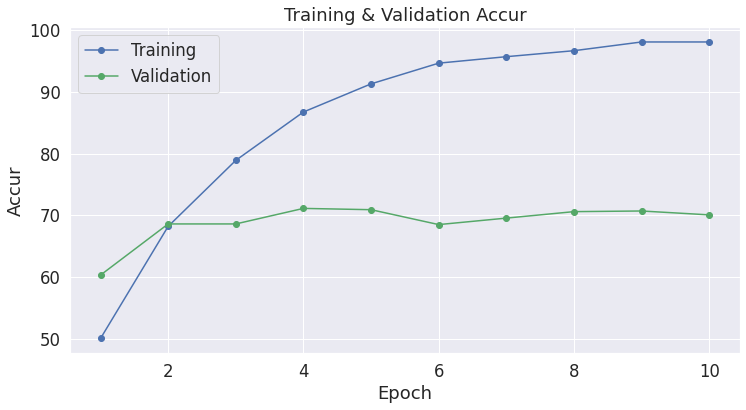

In [23]:
from  matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Train Accur'], 'b-o', label="Training")
plt.plot(df_stats['Valid Accur'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Accur")
plt.xlabel("Epoch")
plt.ylabel("Accur")
plt.legend()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

plt.show()